# Manual Audit for Bias and Fairness in Clinical Risk Prediction

This notebook implements a manual auditing pipeline to evaluate potential bias and fairness issues in a clinical dataset using statistical analysis and visual inspection. The goal is to establish a strong human baseline for fairness assessment, which will later be compared with insights from LLMs.

Derived from the study by Obermeyer et al. (2019) on racial bias in healthcare algorithms, this synthetic dataset mirrors the structure of a proprietary dataset containing over 50,000 patient-years of electronic health records and insurance claims. The dataset `data_new.csv` is used, which contains features related to patient demographics, comorbidities, lab results, healthcare costs, and risk scores. The target variable of interest is `gagne_sum_t`, a clinical comorbidity score representing the patient's disease burden and risk level. A binary version of this target (`target = 1` if `gagne_sum_t >= 2`) is used for fairness analysis.

The audit focuses on:
- Group representation and outcome rates across race, gender, and age group
- Calculation of fairness metrics (Statistical Parity Difference and Disparate Impact Ratio)
- Missing data analysis by subgroup
- Intersectional analysis
- Recommendation rebalancing strategies

Part of the discussion (future work):
- Mutual information

Comparing this manual audit with the insights from LLMs also serves as a foundation for comparing how well LLMs can identify similar patterns or recommend rebalancing strategies.

In [109]:
#Import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.impute import SimpleImputer, KNNImputer
from IPython.display import display
import matplotlib.ticker as mtick

In [103]:
#Load dataset
df = pd.read_csv("data_new.csv")

# 1. Define target and calculate group proportions 
This section creates a binary target variable where patients with a `gagne_sum_t` score of 2 or higher are labeled high risk. It then calculates the proportion of race and gender groups in the dataset and the high-risk rate within each group.

In [104]:
# Defining target 
df["target"] = (df["gagne_sum_t"] >= 2).astype(int)

# Group Proportions 
print("Race proportions:\n", df["race"].value_counts(normalize=True))
print("\nGender proportions:\n", df["dem_female"].value_counts(normalize=True).rename({0: "male", 1: "female"}))

# Target Outcome by Group 
print("\nTarget rate by race:\n", df.groupby("race")["target"].mean())
print("\nTarget rate by gender:\n", df.groupby("dem_female")["target"].mean().rename({0: "male", 1: "female"}))


Race proportions:
 race
white    0.885577
black    0.114423
Name: proportion, dtype: float64

Gender proportions:
 dem_female
female    0.630596
male      0.369404
Name: proportion, dtype: float64

Target rate by race:
 race
black    0.454317
white    0.298320
Name: target, dtype: float64

Target rate by gender:
 dem_female
male      0.337717
female    0.303546
Name: target, dtype: float64


## 1.1 Output group proportions
The cohort is predominantly White (88.6%) and female (63.1%), indicating demographic imbalance. Black patients have a substantially higher rate of having two or more chronic illnesses (45.4%) compared to White patients (29.8%), and males show a slightly higher rate than females.

## 1.2 Derive and analyze age group from one-hot columns
This section combines one-hot encoded age band columns into a single age_group column with readable labels, then calculates the distribution of age groups and the proportion of high-risk individuals in each group to identify potential age-related disparities.

In [105]:
# One-hot column to label mapping
age_band_columns = [
    "dem_age_band_18-24_tm1", "dem_age_band_25-34_tm1",
    "dem_age_band_35-44_tm1", "dem_age_band_45-54_tm1",
    "dem_age_band_55-64_tm1", "dem_age_band_65-74_tm1",
    "dem_age_band_75+_tm1"
]

age_labels = [
    "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75+"
]

# Map one-hot column name to label
column_to_label = dict(zip(age_band_columns, age_labels))

# Create age_group column
df["age_group"] = df[age_band_columns].idxmax(axis=1).map(column_to_label)

# Group distribution
age_group_counts = df["age_group"].value_counts(normalize=True)
print("Age group proportions:\n", age_group_counts)

# Target rate per age group
target_rate_by_age = df.groupby("age_group")["target"].mean()
print("\nTarget rate by age group:\n", target_rate_by_age)

Age group proportions:
 age_group
45-54    0.238377
55-64    0.196581
35-44    0.192235
65-74    0.140415
25-34    0.108622
75+      0.068055
18-24    0.055715
Name: proportion, dtype: float64

Target rate by age group:
 age_group
18-24    0.120309
25-34    0.129836
35-44    0.163254
45-54    0.248689
55-64    0.391554
65-74    0.578978
75+      0.682229
Name: target, dtype: float64


## 1.3 Visualizations data points

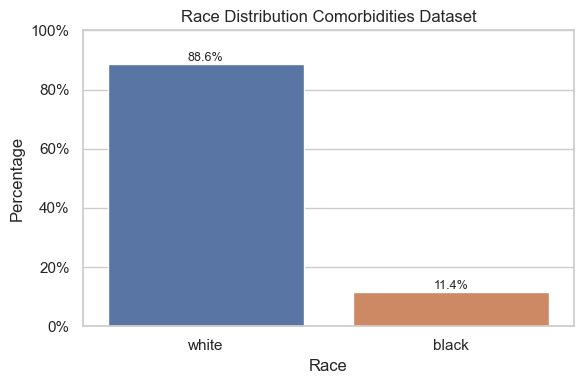

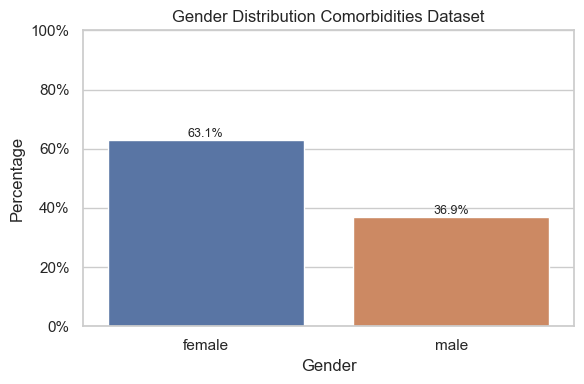

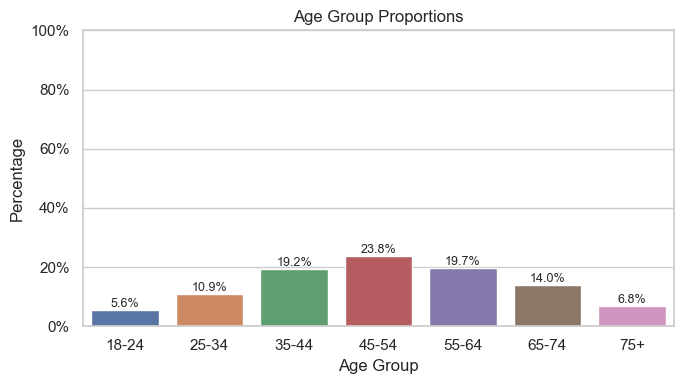

In [106]:
sns.set(style="whitegrid")

# Helper function to add percentage labels
def add_percentage_labels(ax, total=1.0, is_fraction=True):
    for p in ax.patches:
        height = p.get_height()
        label = f"{height * 100:.1f}%" if is_fraction else f"{height:.1f}%"
        ax.annotate(label,
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

# --- Age Group Mapping from One-Hot Encoding ---
age_band_columns = [
    "dem_age_band_18-24_tm1", "dem_age_band_25-34_tm1",
    "dem_age_band_35-44_tm1", "dem_age_band_45-54_tm1",
    "dem_age_band_55-64_tm1", "dem_age_band_65-74_tm1",
    "dem_age_band_75+_tm1"
]

age_labels = [
    "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75+"
]

column_to_label = dict(zip(age_band_columns, age_labels))
df["age_group"] = df[age_band_columns].idxmax(axis=1).map(column_to_label)

# Race Proportions 
race_props = df["race"].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=race_props.index, y=race_props.values)
plt.title("Race Distribution Comorbidities Dataset")
plt.ylabel("Percentage")
plt.xlabel("Race")
plt.ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
add_percentage_labels(ax)
plt.tight_layout()
plt.show()

# Gender Proportions
gender_props = df["dem_female"].value_counts(normalize=True).rename({0: "male", 1: "female"})
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=gender_props.index, y=gender_props.values)
plt.title("Gender Distribution Comorbidities Dataset")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
add_percentage_labels(ax)
plt.tight_layout()
plt.show()


# Age Group Proportions 
age_group_counts = df["age_group"].value_counts(normalize=True).reindex(age_labels)
plt.figure(figsize=(7, 4))
ax = sns.barplot(x=age_group_counts.index, y=age_group_counts.values)
plt.title("Age Group Proportions")
plt.ylabel("Percentage")
plt.xlabel("Age Group")
plt.ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
add_percentage_labels(ax)
plt.tight_layout()
plt.show()

## 1.4 Target distributions for sensitive features with visualization
This code computes and presents how the outcomes gagne_sum_t and risk_score_t differ across demographic groups. It first calculates and displays average values of each outcome by race and gender before rendering comparative bar charts. It then derives an age_group variable from the age indicators, computes mean values for each cohort, and produces a combined visualization that allows direct comparison of the two measures across age categories.

,race,gender,mean_gagne,count
0,black,F,2.058600,3686
1,black,M,2.049578,1896
2,white,F,1.196181,27077
3,white,M,1.377612,16125


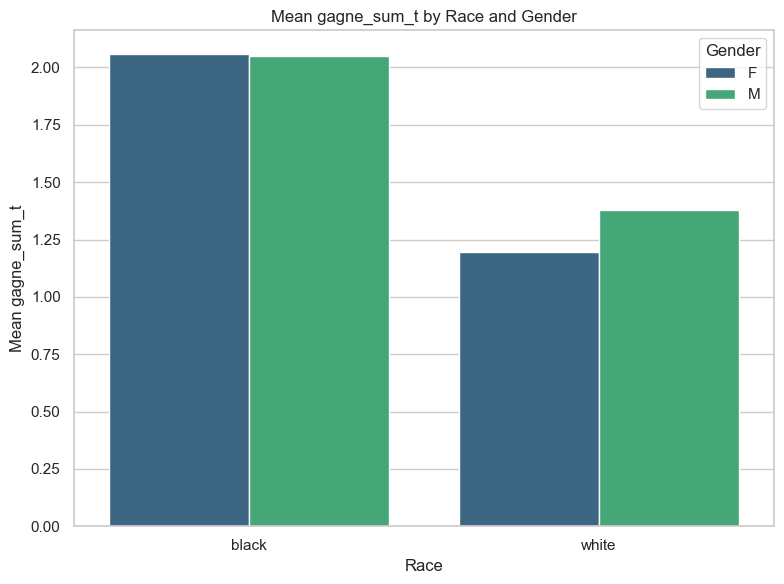

,race,gender,mean_risk,count
0,black,F,5.281573,3686
1,black,M,5.555866,1896
2,white,F,4.194229,27077
3,white,M,4.389017,16125


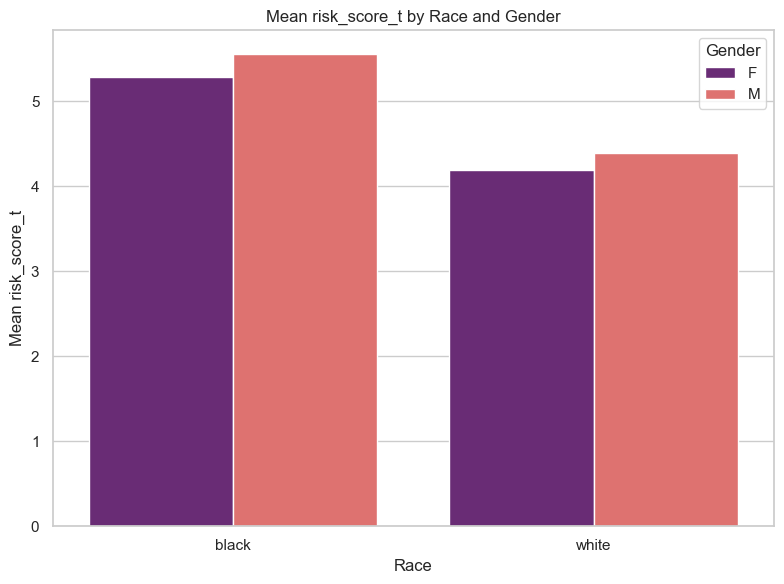

,age_group,mean_gagne,mean_risk,n_gagne,n_risk
0,18-24,0.537528,2.032890,2718,2718
1,25-34,0.611436,2.396759,5299,5299
2,35-44,0.752506,2.866562,9378,9378
3,45-54,1.096139,4.062055,11629,11629
4,55-64,1.632013,5.133254,9590,9590
5,65-74,2.365839,6.708913,6850,6850
6,75+,2.926205,8.075845,3320,3320


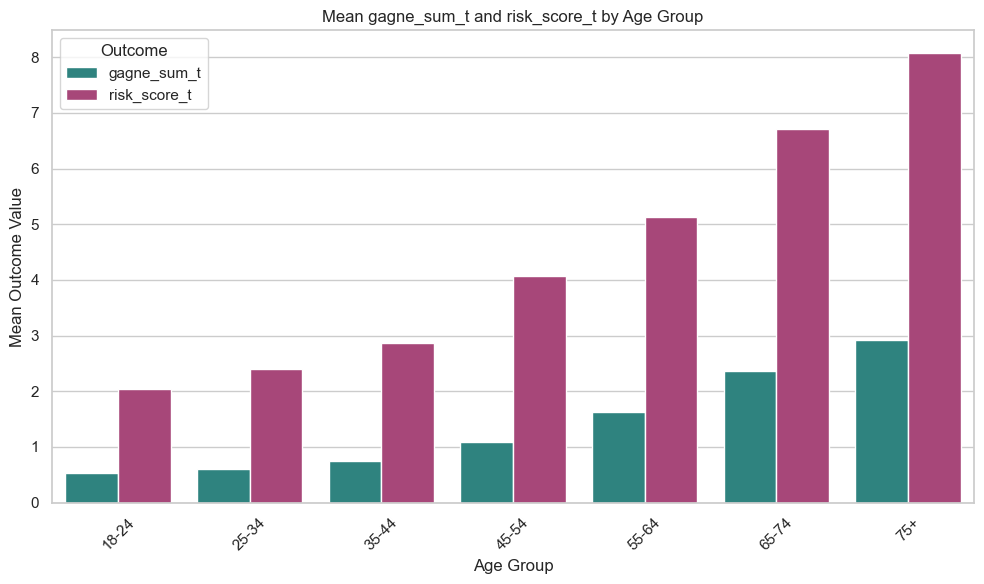

In [108]:
# Ensure your demographic columns are typed correctly
df['race']   = df['race'].astype(str)
df['gender'] = df['dem_female'].map({0: 'M', 1: 'F'})

# MEAN GAGNE_SUM_T BY RACE & GENDER
gagne_summary = (
    df
    .groupby(['race','gender'], as_index=False)
    .agg(mean_gagne=('gagne_sum_t','mean'),
         count      =('gagne_sum_t','size'))
)

# Display the table
display(gagne_summary)

# Plot gagne_sum_t
plt.figure(figsize=(8,6))
sns.barplot(
    data=gagne_summary,
    x='race', y='mean_gagne', hue='gender',
    palette='viridis'
)
plt.title('Mean gagne_sum_t by Race and Gender')
plt.ylabel('Mean gagne_sum_t')
plt.xlabel('Race')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


# MEAN RISK_SCORE_T BY RACE & GENDER
risk_summary = (
    df
    .groupby(['race','gender'], as_index=False)
    .agg(mean_risk=('risk_score_t','mean'),
         count     =('risk_score_t','size'))
)

# Display the table
display(risk_summary)

# Plot risk_score_t
plt.figure(figsize=(8,6))
sns.barplot(
    data=risk_summary,
    x='race', y='mean_risk', hue='gender',
    palette='magma'
)
plt.title('Mean risk_score_t by Race and Gender')
plt.ylabel('Mean risk_score_t')
plt.xlabel('Race')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


# Build age_group from age-band dummies
age_band_cols = [
    'dem_age_band_18-24_tm1','dem_age_band_25-34_tm1',
    'dem_age_band_35-44_tm1','dem_age_band_45-54_tm1',
    'dem_age_band_55-64_tm1','dem_age_band_65-74_tm1',
    'dem_age_band_75+_tm1'
]
age_labels = ['18-24','25-34','35-44','45-54','55-64','65-74','75+']
col_to_label = dict(zip(age_band_cols, age_labels))

df['age_group'] = (
    df[age_band_cols]
      .idxmax(axis=1)
      .map(col_to_label)
)


# Compute means by age_group for both outcomes
summary_age = (
    df
    .groupby('age_group', as_index=False)
    .agg(
        mean_gagne=('gagne_sum_t','mean'),
        mean_risk =('risk_score_t','mean'),
        n_gagne   =('gagne_sum_t','size'),
        n_risk    =('risk_score_t','size')
    )
)

# Display the summary table
display(summary_age)


# (6) Melt for combined plotting
melted = summary_age.melt(
    id_vars=['age_group'],
    value_vars=['mean_gagne','mean_risk'],
    var_name='Outcome',
    value_name='Mean Value'
)
melted['Outcome'] = melted['Outcome'].map({
    'mean_gagne': 'gagne_sum_t',
    'mean_risk' : 'risk_score_t'
})

# Generate a two-color palette from viridis and magma
color1 = sns.color_palette('viridis', 1)[0]
color2 = sns.color_palette('magma', 1)[0]
palette = [color1, color2]

# Plot both means in one visualization
plt.figure(figsize=(10,6))
sns.barplot(
    data=melted,
    x='age_group', y='Mean Value', hue='Outcome',
    palette=palette
)
plt.title('Mean gagne_sum_t and risk_score_t by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mean Outcome Value')
plt.legend(title='Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Fairness metrics 
This code evaluates fairness for two outcome variables using demographic subgroups. The first outcome, high_illness, indicates patients with a high chronic illness burden, defined as having a gagne_sum_t score of three or more. The second, high_risk, flags individuals within the top one percent of predicted medical costs based on risk scores. The analysis includes race, gender, and age group as sensitive attributes.

It computes fairness metrics Statistical Parity Difference (SPD) and Disparate Impact Ratio (DIR) to assess disparities across race, gender, and age. SPD measures the difference in positive outcome rates between groups, with values near zero suggesting fairness. DIR compares these rates as a ratio; values close to one indicate fairness, while values below 0.8 or above 1.25 may reflect potential bias.

In [110]:
# Binarize outcomes
# True‐need proxy: high chronic‐illness burden (gagne_sum_t ≥ 3)
df['high_illness'] = (df['gagne_sum_t'] >= 3).astype(int)

# Cost‐proxy: top 1% of risk scores
cut90 = df['risk_score_t'].quantile(0.99)
df['high_risk'] = (df['risk_score_t'] >= cut90).astype(int)

# Sensitive attributes setup
sensitive = {
    'race': {
        'groups': ['white', 'black'],
        'column': 'race',
        'reference': 'white'
    },
    'gender': {
        'groups': [0, 1],           # 0 = male/reference, 1 = female
        'column': 'dem_female',
        'reference': 0
    },
    'age': {
        'groups': [
            'dem_age_band_18-24_tm1',
            'dem_age_band_25-34_tm1',
            'dem_age_band_35-44_tm1',
            'dem_age_band_45-54_tm1',
            'dem_age_band_55-64_tm1',
            'dem_age_band_65-74_tm1',
            'dem_age_band_75+_tm1'
        ],
        'column': None,            # indicator columns
        'reference': 'dem_age_band_18-24_tm1'
    }
}

# Metric computation function
def compute_spd_dir(df, outcome, attr_info):
    results = []
    if attr_info['column'] is not None:
        col = attr_info['column']
        ref = attr_info['reference']
        p_ref = df[df[col] == ref][outcome].mean()
        for grp in attr_info['groups']:
            p_grp = df[df[col] == grp][outcome].mean()
            spd   = p_grp - p_ref
            dirr  = p_grp / p_ref if p_ref else float('nan')
            results.append({
                'attribute': col,
                'group': grp,
                'outcome': outcome,
                'pos_rate': p_grp,
                'SPD': spd,
                'DIR': dirr
            })
    else:
        ref_col = attr_info['reference']
        p_ref = df[df[ref_col] == 1][outcome].mean()
        for col in attr_info['groups']:
            p_grp = df[df[col] == 1][outcome].mean()
            spd   = p_grp - p_ref
            dirr  = p_grp / p_ref if p_ref else float('nan')
            results.append({
                'attribute': 'age_band',
                'group': col,
                'outcome': outcome,
                'pos_rate': p_grp,
                'SPD': spd,
                'DIR': dirr
            })
    return pd.DataFrame(results)

# Compute metrics for both outcomes and all sensitive attributes
all_results = []
for name, info in sensitive.items():
    for outcome in ['high_risk', 'high_illness']:
        dfm = compute_spd_dir(df, outcome, info)
        dfm['sensitive_attr'] = name
        all_results.append(dfm)

fairness_df = pd.concat(all_results, ignore_index=True)

# Formatting rule for DIR: if >1.25, show as "1:<value>"
def format_dir(d):
    return f"1:{d:.2f}" if d > 1.25 else f"{d:.2f}"

# Output tables
titles = {
    'high_risk':    ' Risk Score\n',
    'high_illness': ' Gagne_sum_t\n'
}

for outcome, title in titles.items():
    print(title)
    sub = fairness_df[fairness_df['outcome'] == outcome]
    for attr in ['race', 'gender', 'age']:
        block = sub[sub['sensitive_attr'] == attr].copy()
        # apply formatting
        block['SPD'] = block['SPD'].map(lambda x: f"{x:.3f}")
        block['DIR'] = block['DIR'].map(format_dir)
        attr_name = attr.capitalize() if attr != 'age' else 'Age Band'
        print(f"{attr_name}\n")
        print(
            block[['group','SPD','DIR']]
            .rename(columns={'group':'Group','SPD':'SPD','DIR':'DIR'})
            .to_markdown(index=False)
        )
        print()


 Risk Score

Race

| Group   |   SPD | DIR    |
|:--------|------:|:-------|
| white   | 0     | 1.00   |
| black   | 0.017 | 1:3.16 |

Gender

|   Group |    SPD |   DIR |
|--------:|-------:|------:|
|       0 |  0     |  1    |
|       1 | -0.003 |  0.78 |

Age Band

| Group                  |    SPD | DIR    |
|:-----------------------|-------:|:-------|
| dem_age_band_18-24_tm1 |  0     | 1.00   |
| dem_age_band_25-34_tm1 | -0.001 | 0.86   |
| dem_age_band_35-44_tm1 |  0.003 | 1:1.71 |
| dem_age_band_45-54_tm1 |  0.007 | 1:2.73 |
| dem_age_band_55-64_tm1 |  0.007 | 1:2.73 |
| dem_age_band_65-74_tm1 |  0.012 | 1:4.04 |
| dem_age_band_75+_tm1   |  0.015 | 1:4.87 |

 Gagne_sum_t

Race

| Group   |   SPD | DIR    |
|:--------|------:|:-------|
| white   | 0     | 1.00   |
| black   | 0.127 | 1:1.73 |

Gender

|   Group |    SPD |   DIR |
|--------:|-------:|------:|
|       0 |  0     |  1    |
|       1 | -0.028 |  0.86 |

Age Band

| Group                  |   SPD | DIR    |
|:-----

## 2.1 Output
Black patients and older adults are disproportionately flagged: for example, the DIR for Black patients on risk score is 1:3.16 (≈0.32), and for patients aged 75+, it reaches 1:4.87 (≈0.21), indicating significantly higher classification rates than the reference groups. For chronic illness, the oldest group shows a DIR of 1:9.40 (≈0.11), while Black patients have a DIR of 1:1.73 (≈0.58). Gender differences are smaller, though females consistently show lower DIR values (≈0.78–0.86).

## 2.2 Visualisation fairness metrics
The corresponding visualizations present SPD and DIR values as bar charts for each sensitive attribute including race, gender, and age group. These plots help to visually compare subgroup outcomes and clearly identify where fairness thresholds, such as DIR values below 0.8, are not met.

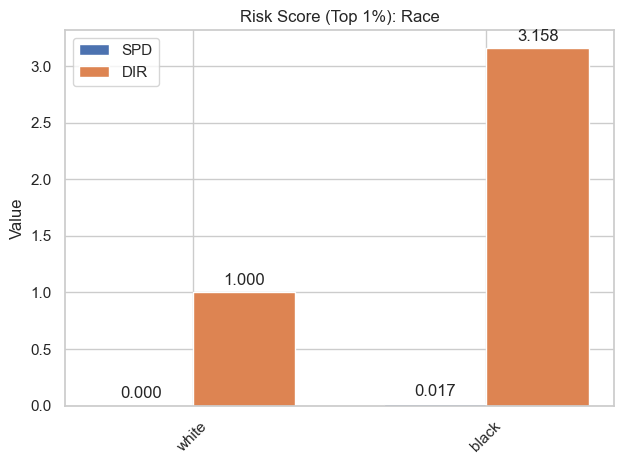

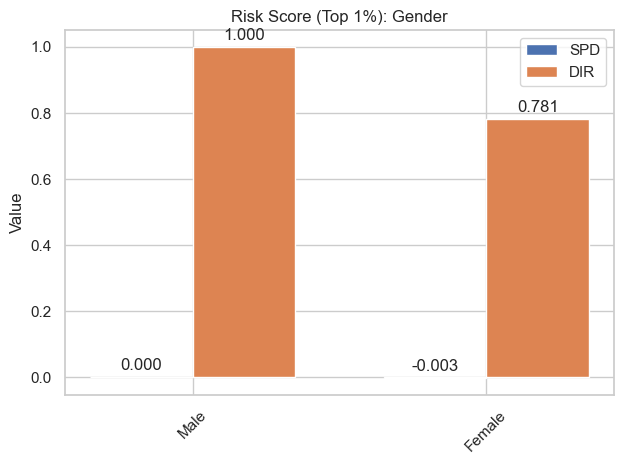

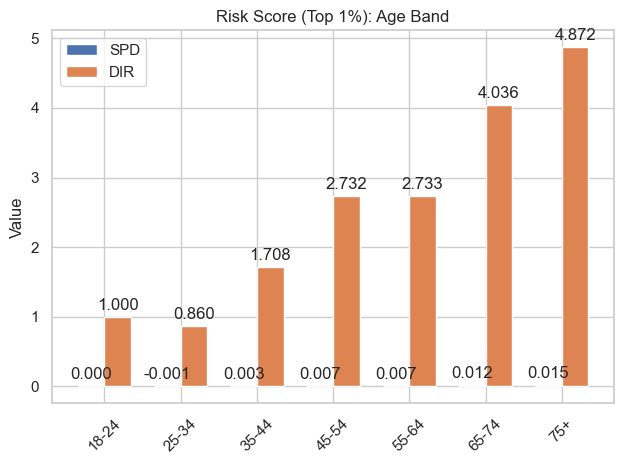

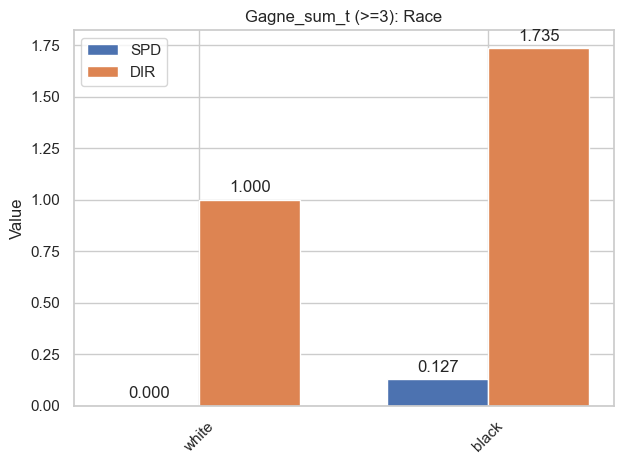

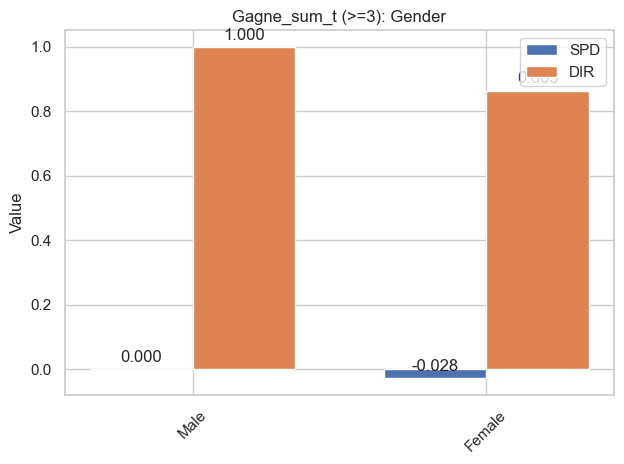

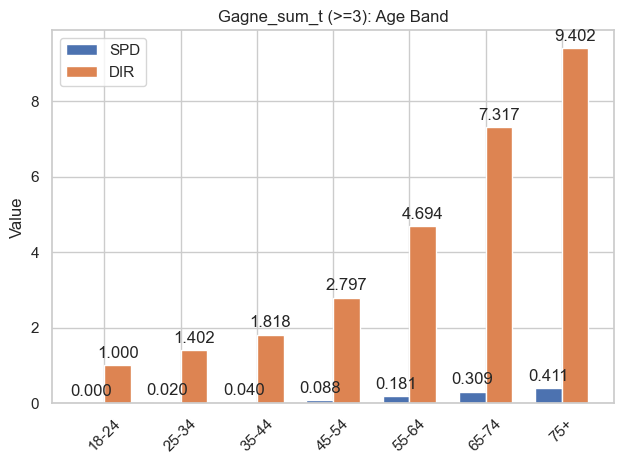

In [81]:
# Mapping for age labels
age_labels = ['18-24','25-34','35-44','45-54','55-64','65-74','75+']

def plot_for_outcome(outcome, title_prefix):
    df_out = fairness_df[fairness_df['outcome'] == outcome]
    
    # 1) Race
    df_r = df_out[df_out['sensitive_attr']=='race']
    labels_r = df_r['group'].tolist()
    spd_r    = df_r['SPD'].astype(float).values
    dir_r    = df_r['DIR'].astype(float).values
    
    # 2) Gender
    df_g = df_out[df_out['sensitive_attr']=='gender']
    labels_g = ['Male' if g==0 else 'Female' for g in df_g['group']]
    spd_g    = df_g['SPD'].astype(float).values
    dir_g    = df_g['DIR'].astype(float).values
    
    # 3) Age
    df_a = df_out[df_out['sensitive_attr']=='age']
    labels_a = age_labels
    spd_a    = df_a['SPD'].astype(float).values
    dir_a    = df_a['DIR'].astype(float).values
    
    def make_chart(labels, spd_vals, dir_vals, title):
        x = np.arange(len(labels))
        w = 0.35
        fig, ax = plt.subplots()
        bars1 = ax.bar(x - w/2, spd_vals, w, label='SPD')
        bars2 = ax.bar(x + w/2, dir_vals, w, label='DIR')
        for bar in bars1 + bars2:
            h = bar.get_height()
            ax.annotate(f'{h:.3f}',
                        xy=(bar.get_x()+bar.get_width()/2, h),
                        xytext=(0,3), textcoords='offset points',
                        ha='center', va='bottom')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_title(title)
        ax.set_ylabel('Value')
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    make_chart(labels_r, spd_r, dir_r, f'{title_prefix}: Race')
    make_chart(labels_g, spd_g, dir_g, f'{title_prefix}: Gender')
    make_chart(labels_a, spd_a, dir_a, f'{title_prefix}: Age Band')

# plot for Risk Score
plot_for_outcome('high_risk', 'Risk Score (Top 1%)')

# plot for Gagne_sum_t
plot_for_outcome('high_illness', 'Gagne_sum_t (>=3)')


# 3. Missing Data Bias 

This code performs a comprehensive missing‐data audit by quantifying and ranking the extent of absent values across all variables, calculating both absolute counts and percentage rates, and then examining how these gaps manifest within demographic subgroups such as gender, race, and age cohorts to inform subsequent data‐quality and imputation strategies.

Rows: 48,784  |  Columns: 160

Top 20 variables by % missing
|                        |   n_missing |   pct_missing |
|:-----------------------|------------:|--------------:|
| ghba1c_mean_t          |       35532 |       72.8354 |
| ldl_mean_t             |       29328 |       60.1181 |
| hct_mean_t             |       27516 |       56.4037 |
| cre_mean_t             |       24813 |       50.863  |
| bps_mean_t             |       10668 |       21.8678 |
| risk_score_t           |           0 |        0      |
| ghba1c_max-normal_tm1  |           0 |        0      |
| ghba1c_min-high_tm1    |           0 |        0      |
| ghba1c_min-normal_tm1  |           0 |        0      |
| ghba1c_mean-low_tm1    |           0 |        0      |
| ghba1c_mean-high_tm1   |           0 |        0      |
| ghba1c_mean-normal_tm1 |           0 |        0      |
| ghba1c_max-low_tm1     |           0 |        0      |
| ghba1c_max-high_tm1    |           0 |        0      |
| hct_min-normal_tm1     | 

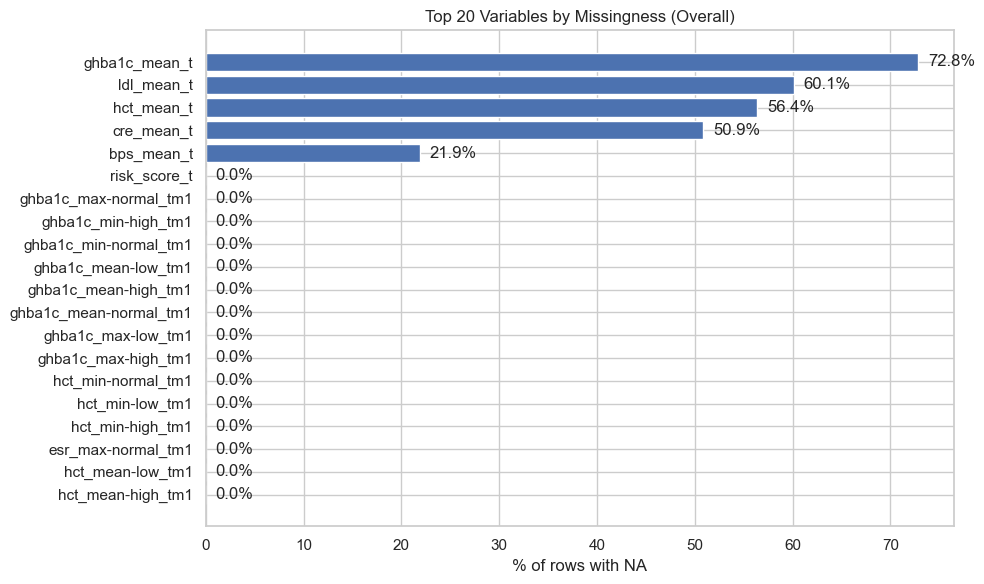

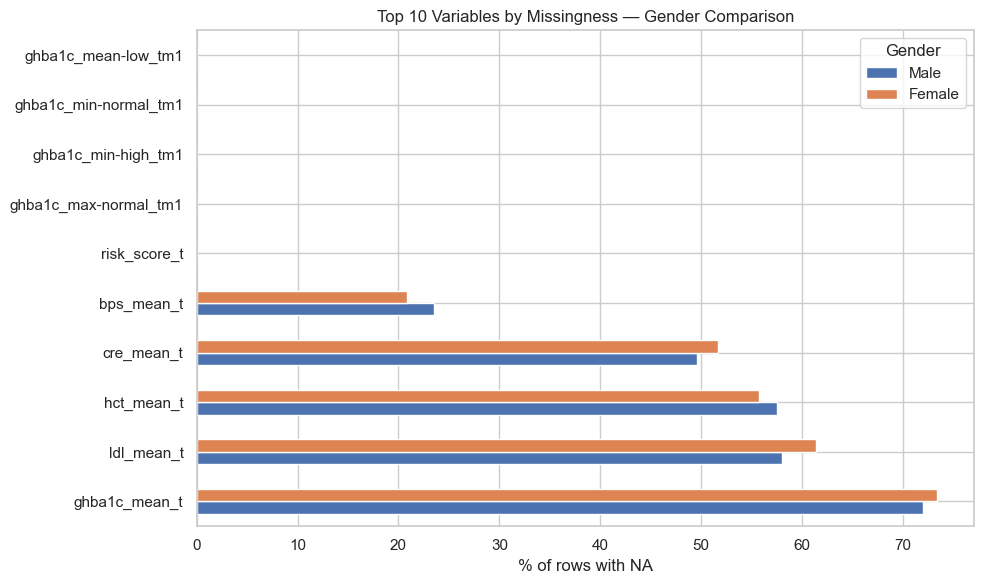


Missingness by Gender (Top 10 Variables):
|                       |    Male |   Female |
|:----------------------|--------:|---------:|
| ghba1c_mean_t         | 71.9494 |  73.3544 |
| ldl_mean_t            | 58.0267 |  61.3432 |
| hct_mean_t            | 57.5218 |  55.7488 |
| cre_mean_t            | 49.5367 |  51.64   |
| bps_mean_t            | 23.5669 |  20.8725 |
| risk_score_t          |  0      |   0      |
| ghba1c_max-normal_tm1 |  0      |   0      |
| ghba1c_min-high_tm1   |  0      |   0      |
| ghba1c_min-normal_tm1 |  0      |   0      |
| ghba1c_mean-low_tm1   |  0      |   0      |


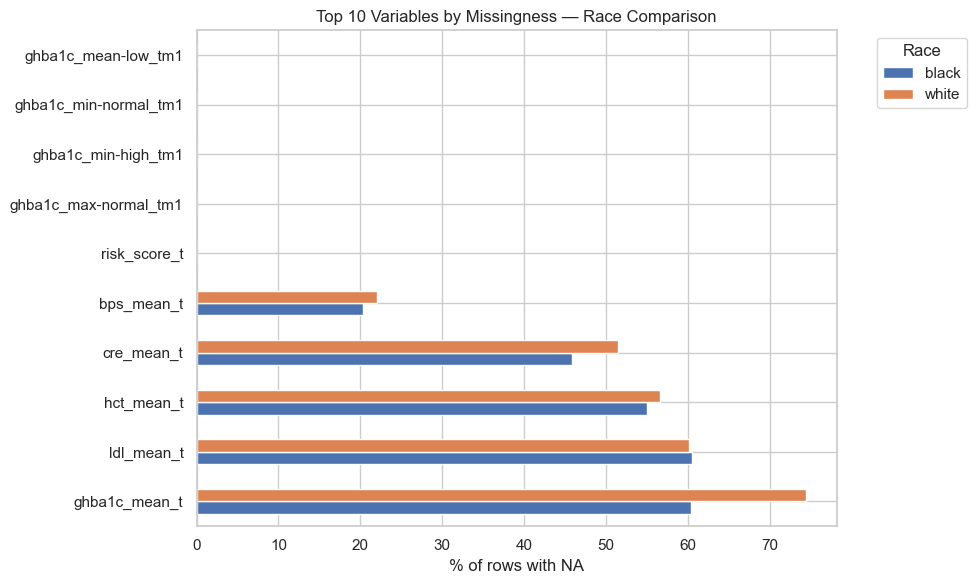


Missingness by Race (Top 10 Variables):
|                       |   black |   white |
|:----------------------|--------:|--------:|
| ghba1c_mean_t         | 60.3547 | 74.4479 |
| ldl_mean_t            | 60.5159 | 60.0667 |
| hct_mean_t            | 54.9982 | 56.5853 |
| cre_mean_t            | 45.8796 | 51.5069 |
| bps_mean_t            | 20.2795 | 22.0731 |
| risk_score_t          |  0      |  0      |
| ghba1c_max-normal_tm1 |  0      |  0      |
| ghba1c_min-high_tm1   |  0      |  0      |
| ghba1c_min-normal_tm1 |  0      |  0      |
| ghba1c_mean-low_tm1   |  0      |  0      |


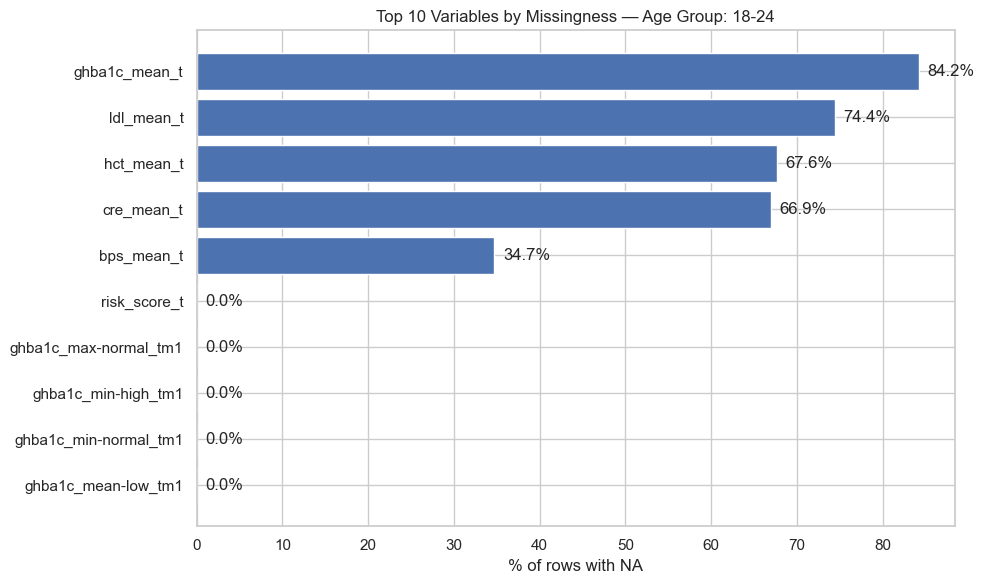

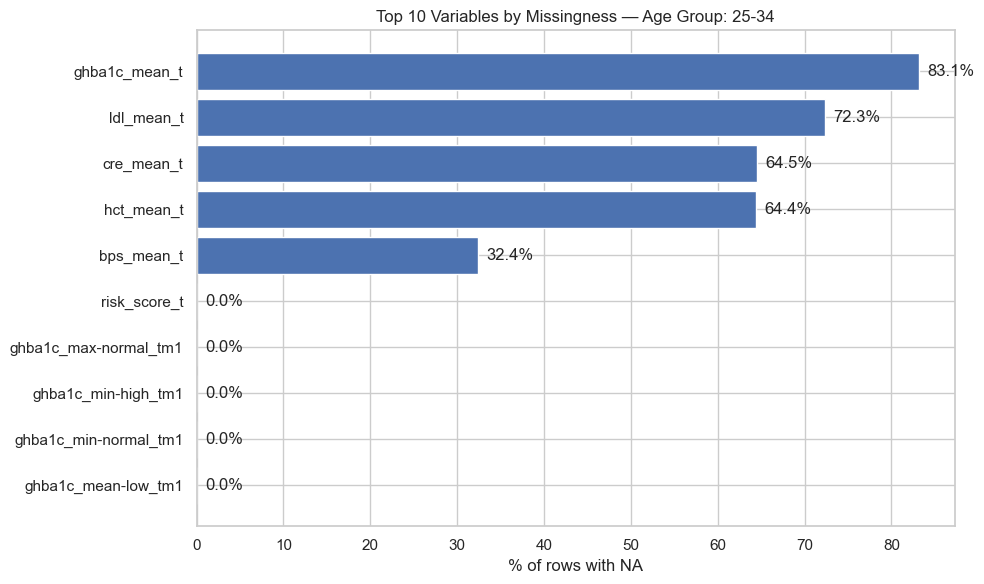

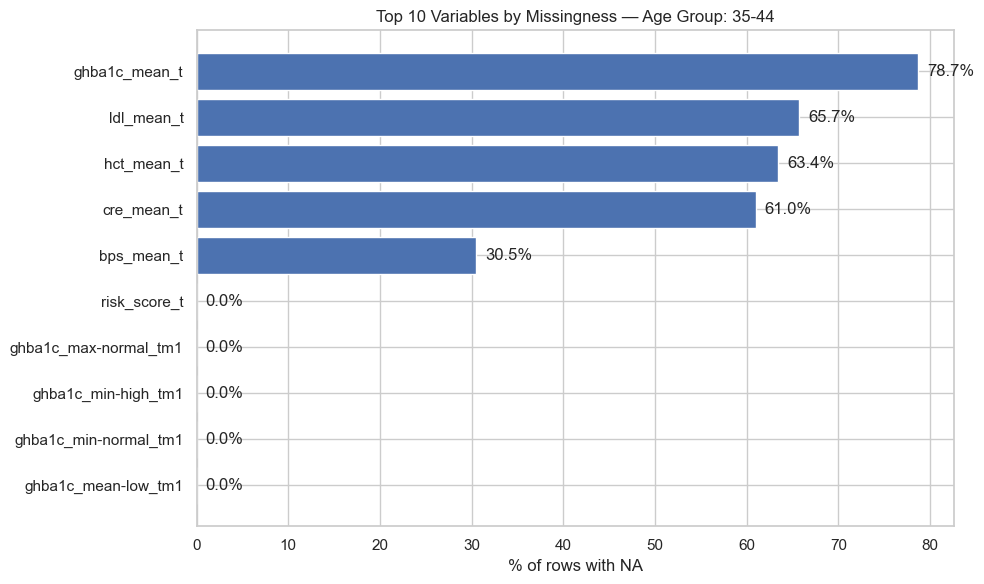

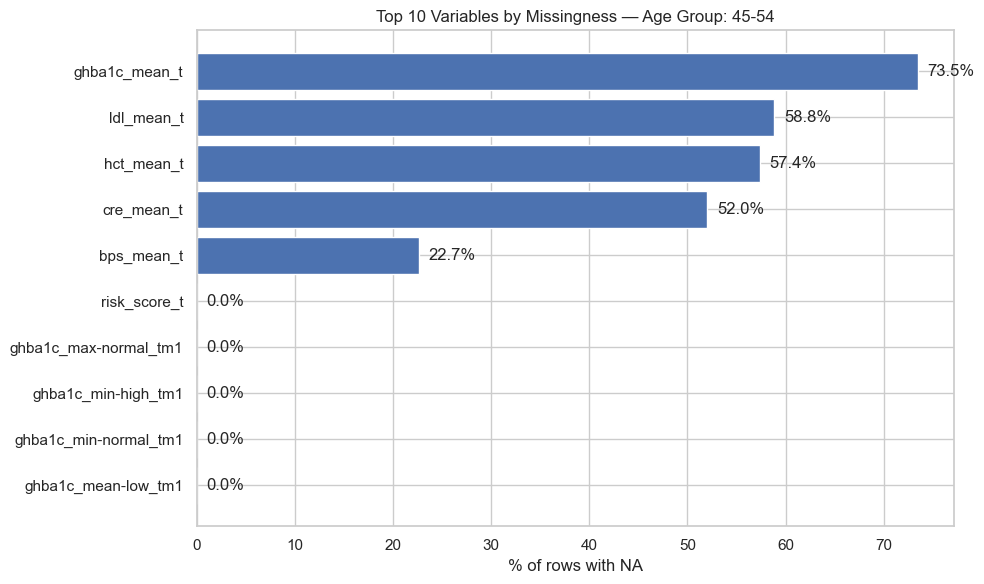

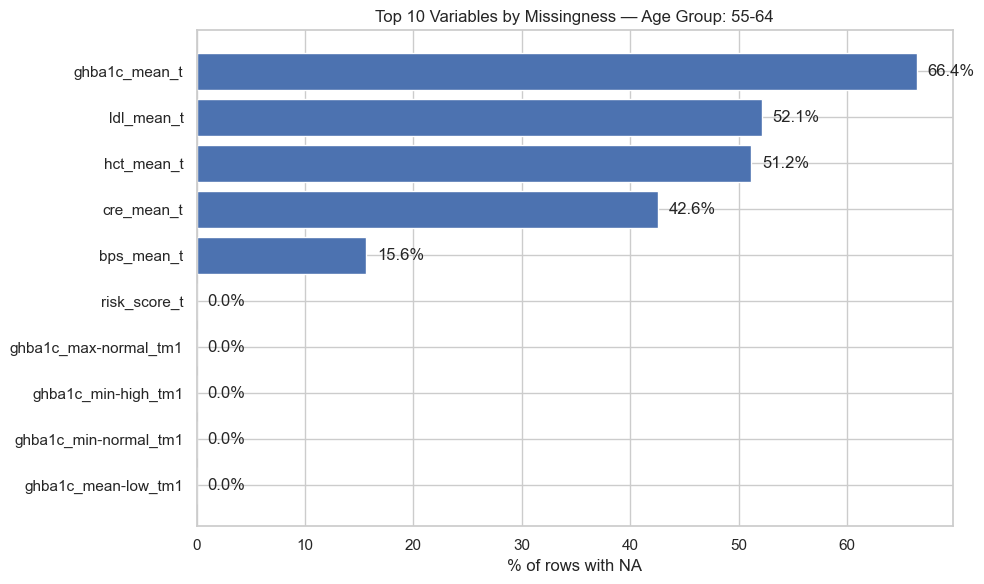

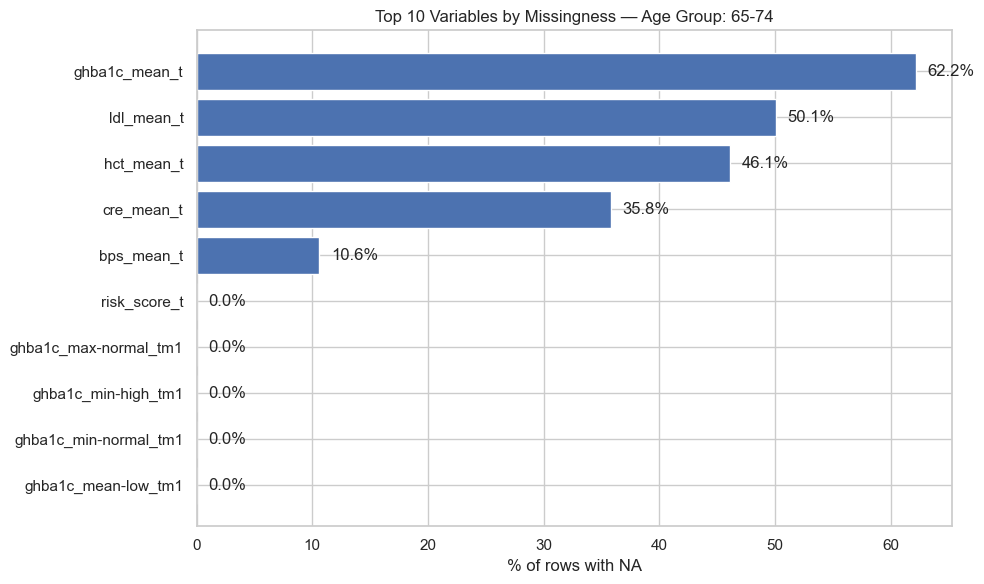

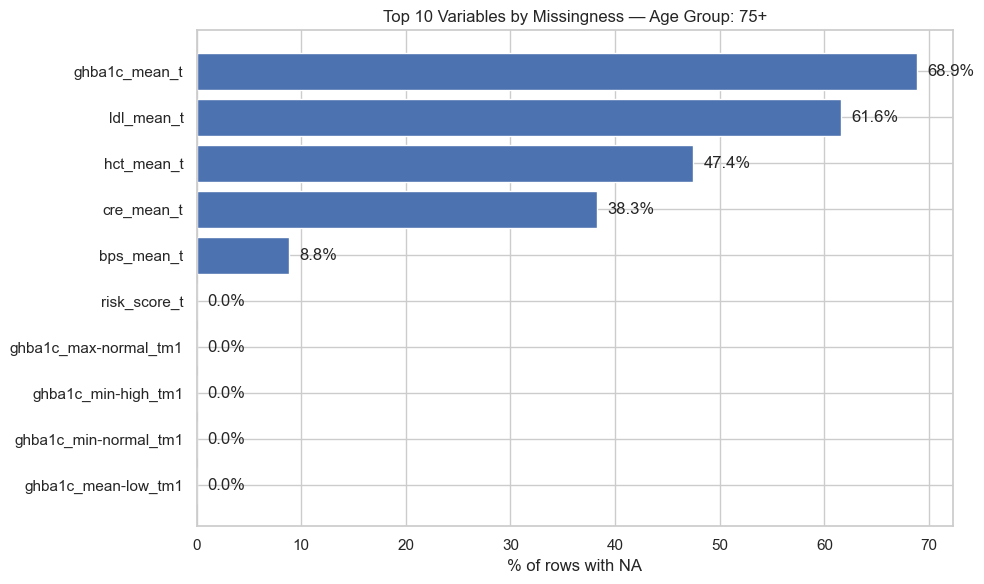


Missingness by Age Group (Top 10 Variables):

Age Group: 18-24
|                       |   pct_missing |
|:----------------------|--------------:|
| ghba1c_mean_t         |       84.2163 |
| ldl_mean_t            |       74.3929 |
| hct_mean_t            |       67.6233 |
| cre_mean_t            |       66.9242 |
| bps_mean_t            |       34.7314 |
| risk_score_t          |        0      |
| ghba1c_max-normal_tm1 |        0      |
| ghba1c_min-high_tm1   |        0      |
| ghba1c_min-normal_tm1 |        0      |
| ghba1c_mean-low_tm1   |        0      |

Age Group: 25-34
|                       |   pct_missing |
|:----------------------|--------------:|
| ghba1c_mean_t         |       83.1478 |
| ldl_mean_t            |       72.3344 |
| cre_mean_t            |       64.4839 |
| hct_mean_t            |       64.4273 |
| bps_mean_t            |       32.3646 |
| risk_score_t          |        0      |
| ghba1c_max-normal_tm1 |        0      |
| ghba1c_min-high_tm1   |        0  

In [41]:
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

if 'age_group' not in df.columns:
    age_band_cols = [
        'dem_age_band_18-24_tm1',
        'dem_age_band_25-34_tm1',
        'dem_age_band_35-44_tm1',
        'dem_age_band_45-54_tm1',
        'dem_age_band_55-64_tm1',
        'dem_age_band_65-74_tm1',
        'dem_age_band_75+_tm1'
    ]
    age_labels = ['18-24','25-34','35-44','45-54','55-64','65-74','75+']
    col_to_label = dict(zip(age_band_cols, age_labels))

    df['age_group'] = (
        df[age_band_cols]
          .idxmax(axis=1)
          .map(col_to_label)
    )

# Overall missingness
missing = (
    df.isna()
      .agg(['sum', 'mean'])
      .T
      .rename(columns={'sum': 'n_missing', 'mean': 'pct_missing'})
)
missing['pct_missing'] *= 100
missing_sorted = missing.sort_values('pct_missing', ascending=False)

print("\nTop 20 variables by % missing")
print(missing_sorted.head(20).to_markdown())

overall_pct = df.isna().values.mean() * 100
print(f"\nOverall missing rate across all cells: {overall_pct:.2f}%")

# Plot: Overall missingness
top_n = 20
top_missing = missing_sorted.head(top_n)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_missing.index[::-1], top_missing['pct_missing'][::-1])
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center')

plt.xlabel('% of rows with NA')
plt.title(f'Top {top_n} Variables by Missingness (Overall)')
plt.tight_layout()
plt.show()

# Number of variables to show in subgroup plots
top_n = 10
# Combined Plot: Gender
gender_missing = df.groupby('dem_female').apply(lambda g: g.isna().mean() * 100)
gender_missing.index = gender_missing.index.map({0: 'Male', 1: 'Female'})

top_gender_cols = gender_missing.max().sort_values(ascending=False).head(top_n).index
gender_plot_data = gender_missing[top_gender_cols].T

gender_plot_data.plot(kind='barh', figsize=(10, 6))
plt.xlabel('% of rows with NA')
plt.title(f'Top {top_n} Variables by Missingness — Gender Comparison')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

print("\nMissingness by Gender (Top 10 Variables):")
print(gender_plot_data.to_markdown())

# Combined Plot: Race
if 'race' in df.columns:
    race_missing = df.groupby('race').apply(lambda g: g.isna().mean() * 100)
    top_race_cols = race_missing.max().sort_values(ascending=False).head(top_n).index
    race_plot_data = race_missing[top_race_cols].T

    race_plot_data.plot(kind='barh', figsize=(10, 6))
    plt.xlabel('% of rows with NA')
    plt.title(f'Top {top_n} Variables by Missingness — Race Comparison')
    plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("\nMissingness by Race (Top 10 Variables):")
    print(race_plot_data.to_markdown())
else:
    print("Column 'race' not found in dataset.")

# Missingness by age group
if 'age_group' in df.columns:
    age_missing = df.groupby('age_group').apply(lambda g: g.isna().mean() * 100)
    age_missing_table = {}

    for age in age_missing.index:
        vals = age_missing.loc[age].sort_values(ascending=False).head(top_n)
        age_missing_table[age] = vals

        plt.figure(figsize=(10, 6))
        bars = plt.barh(vals.index[::-1], vals[::-1])
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', va='center')
        plt.xlabel('% of rows with NA')
        plt.title(f'Top {top_n} Variables by Missingness — Age Group: {age}')
        plt.tight_layout()
        plt.show()

    print("\nMissingness by Age Group (Top 10 Variables):")
    for age, table in age_missing_table.items():
        print(f"\nAge Group: {age}")
        print(table.to_frame(name='pct_missing').to_markdown())
else:
    print("Column 'age_group' not found in dataset.")


In [2]:
groups = {
    "year_t outcomes"   : [c for c in df.columns if c.endswith("_t") and not c.endswith("_tm1")],
    "year_t‑1 features" : [c for c in df.columns if c.endswith("_tm1")],
    "demographics"      : ["race", "dem_female"]  # plus any age‑band dummies you keep
}

for gname, cols in groups.items():
    pct = df[cols].isna().values.mean() * 100
    print(f"{gname:20}: {pct:5.2f}% missing on average over {len(cols)} variables")


year_t outcomes     : 26.21% missing on average over 10 variables
year_t‑1 features   :  0.00% missing on average over 148 variables
demographics        :  0.00% missing on average over 2 variables


### 3.1 Output
Patients aged 35-64 represented over 60% of the cohort, and the probability of the target outcome increases monotonically from approximately 12% in the 18-24 band to 68% in the 75+ band. This suggests that age alone captures a large share of the risk signal. 

Lab values and biomarkers display substantial missingness: systolic blood pressure is missing in about 20-22% of records, whereas HbA1c, hematocrit, creatinine, and LDL are missing in 55-75% of records. The pattern of missingness varies by demographic subgroup. White patients exhibit slightly higher missingness in HbA1c and creatinine compared with Black patients, and male and female patients differ modestly in which labs are unrecorded. These discrepancies indicate that any imputation strategy must account for potential bias introduced by nonrandom missingness across key subgroups. 

# 4. Intersectional Group Analysis gagne_sum_t

The following code implements an intersectional assessment of chronic-illness burden (gagne_sum_t) across race, gender, and age data. After casting the race and gender indicators and identifying all age-band groups, the code systematically iterates through each race-gender pair, race-age-band pair, gender-age-band pair, and the full three-way intersection. For each subgroup with at least thirty data points, it records both the sample size and the mean gagne_sum_t. The minimum subgroup size is n >= 30, because then it is less likely to fluctuate simply because of outliers, according to the Central Limit Theorem. The resulting tables allow precise identification of demographic intersections exhibiting unusually high or low comorbidity levels, thereby highlighting subpopulations for which model performance and fairness should be most carefully evaluated. 

In [71]:
#For gagne_sum

# Ensuring '?' in race and fill missing values etc. 
df['race'] = df['race'].astype(str)
df['dem_female'] = df['dem_female'].astype(int)

# Intersectional summaries for 'gagne_sum_t'
outcome = 'gagne_sum_t'
age_bands = [c for c in df.columns if c.startswith('dem_age_band')]
min_n = 30

def print_summary(title, rows):
    print(f"\n {title} ")
    print(pd.DataFrame(rows).sort_values('n', ascending=False).reset_index(drop=True))

# Race × Gender
rows = []
for race in df['race'].unique():
    for gender in [0, 1]:
        mask = (df['race'] == race) & (df['dem_female'] == gender)
        n = mask.sum()
        if n < min_n: continue
        rows.append({
            'race': race,
            'gender': 'F' if gender else 'M',
            'n': n,
            f'mean_{outcome}': df.loc[mask, outcome].mean()
        })
print_summary('Race × Gender (gagne_sum_t)', rows)

# Race × Age Band
rows = []
for race in df['race'].unique():
    for band in age_bands:
        mask = (df['race'] == race) & (df[band] == 1)
        n = mask.sum()
        if n < min_n: continue
        rows.append({
            'race': race,
            'age_band': band,
            'n': n,
            f'mean_{outcome}': df.loc[mask, outcome].mean()
        })
print_summary('Race × Age Band (gagne_sum_t)', rows)

# Gender × Age Band
rows = []
for gender in [0, 1]:
    for band in age_bands:
        mask = (df['dem_female'] == gender) & (df[band] == 1)
        n = mask.sum()
        if n < min_n: continue
        rows.append({
            'gender': 'F' if gender else 'M',
            'age_band': band,
            'n': n,
            f'mean_{outcome}': df.loc[mask, outcome].mean()
        })
print_summary('Gender × Age Band (gagne_sum_t)', rows)

# Race × Gender × Age Band
rows = []
for race in df['race'].unique():
    for gender in [0, 1]:
        for band in age_bands:
            mask = (
                (df['race'] == race) &
                (df['dem_female'] == gender) &
                (df[band] == 1)
            )
            n = mask.sum()
            if n < min_n: continue
            rows.append({
                'race': race,
                'gender': 'F' if gender else 'M',
                'age_band': band,
                'n': n,
                f'mean_{outcome}': df.loc[mask, outcome].mean()
            })
print_summary('Race × Gender × Age Band (gagne_sum_t)', rows)


 Race × Gender (gagne_sum_t) 
    race gender      n  mean_gagne_sum_t
0  white      F  27077          1.196181
1  white      M  16125          1.377612
2  black      F   3686          2.058600
3  black      M   1896          2.049578

 Race × Age Band (gagne_sum_t) 
     race                age_band      n  mean_gagne_sum_t
0   white  dem_age_band_45-54_tm1  10269          0.980232
1   white  dem_age_band_55-64_tm1   8563          1.528787
2   white  dem_age_band_35-44_tm1   8343          0.680690
3   white  dem_age_band_65-74_tm1   6162          2.236287
4   white  dem_age_band_25-34_tm1   4745          0.558693
5   white    dem_age_band_75+_tm1   3037          2.788607
6   white  dem_age_band_18-24_tm1   1601          0.472205
7   black  dem_age_band_45-54_tm1   1396          1.961318
8   black  dem_age_band_35-44_tm1   1138          1.355009
9   black  dem_age_band_55-64_tm1   1027          2.492697
10  black  dem_age_band_65-74_tm1    778          3.204370
11  black  dem_age_band

## 4.1 Output conclusion intersectional group analysis gagne_sum_t
The output reveals that the multimorbidity increases with age and is significantly higher among Black patients. White men and women average 1.38 and 1.20 comorbidities, while Black men and women average over 2.05 despite smaller sample sizes. Scores rise with age across all groups, from under 0.50 in ages 18-24 to 2.80 (White) and 3.59 (Black) in the 75+ group. For gender and age, it shows that it is slightly lower for women than men until late life. The highest burden is among Black women, where the mean is 3.47, and the lowest among White women, where the mean is 0.52. This highlights a need for targeted interventions in high-risk groups.

## 4.2 Visualization intersectionality gagne_sum_t

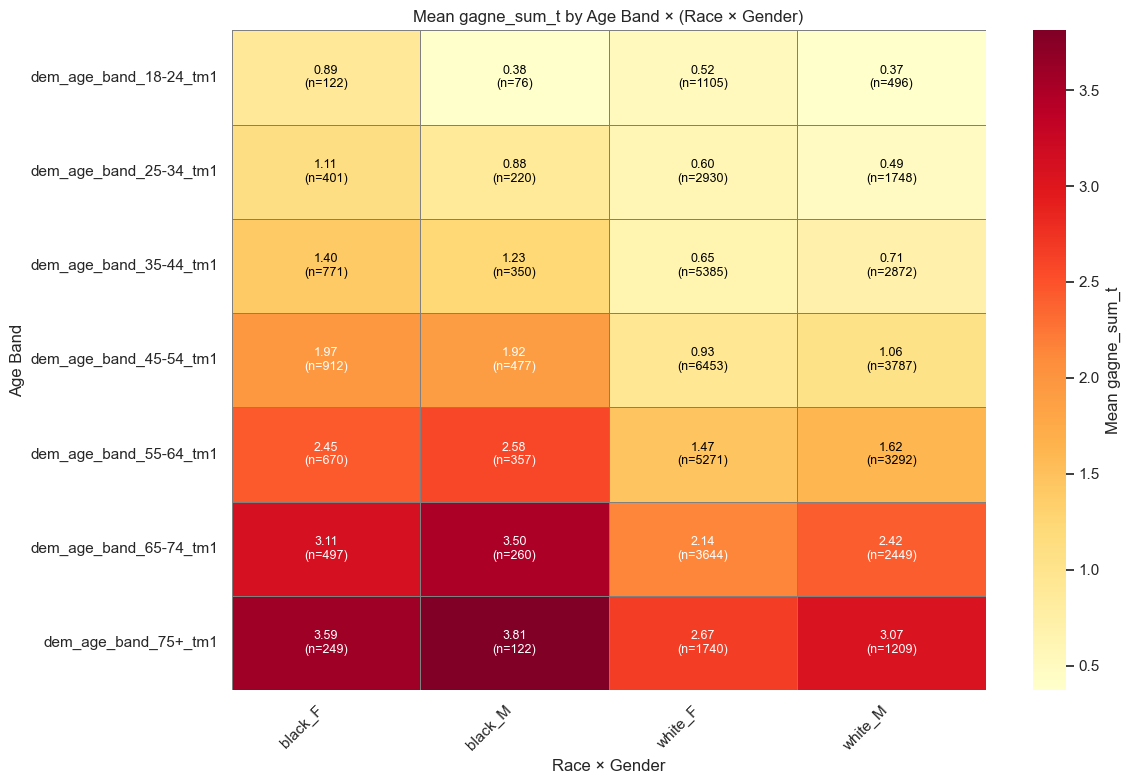

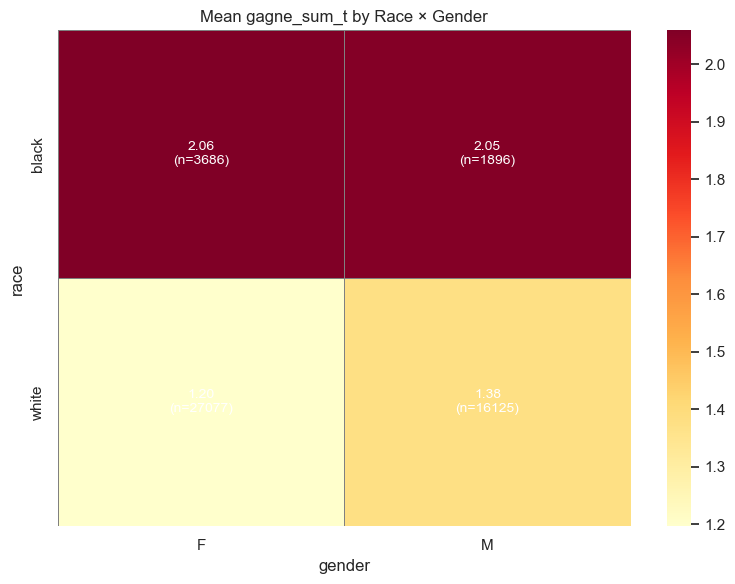

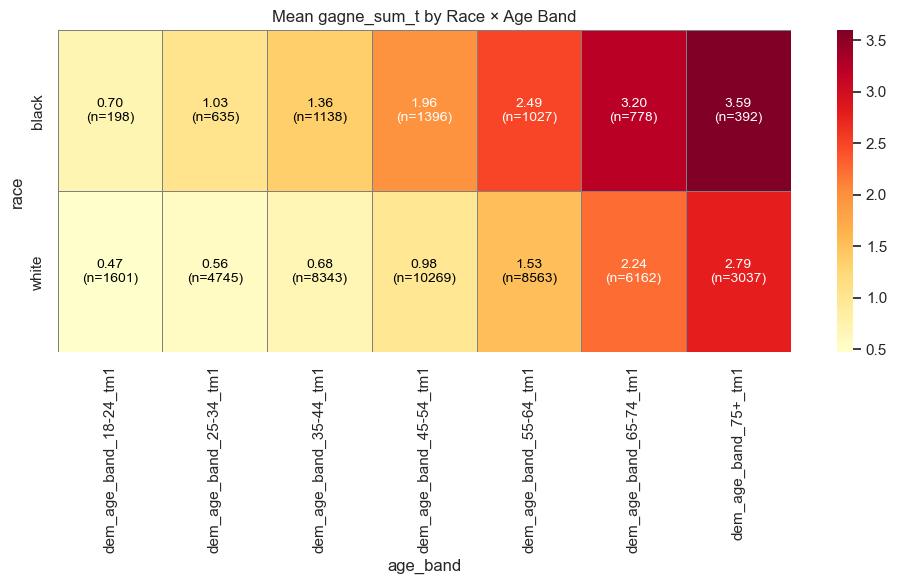

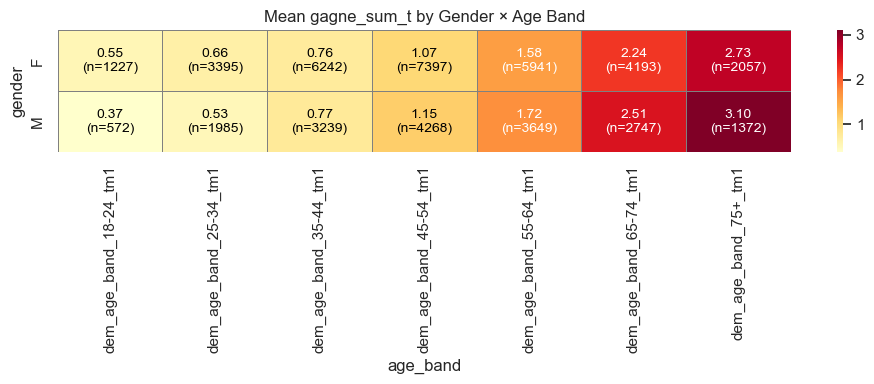

In [98]:
def extract_band(row):
    for col in age_bands:
        if row[col] == 1:
            return col
    return None

age_bands = [c for c in df.columns if c.startswith('dem_age_band')]
df['age_band'] = df.apply(extract_band, axis=1)
df = df[df['age_band'].notna()]  # drop any with no band

# Build composite Race×Gender key
df['race_gender'] = (
    df['race'].astype(str) + '_' +
    df['dem_female'].map({0:'M',1:'F'})
)

# Aggregate mean & count
summary = (
    df.groupby(['age_band','race_gender'])
      .agg(n=('gagne_sum_t','size'),
           rate=('gagne_sum_t','mean'))
      .reset_index()
)

# Pivot to matrices
mat_rate = summary.pivot(index='age_band',  columns='race_gender', values='rate')
mat_n    = summary.pivot(index='age_band',  columns='race_gender', values='n')

# Plot single heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    mat_rate,
    mask=mat_rate.isna(),
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean gagne_sum_t'},
    annot=False
)

vmax = np.nanmax(mat_rate.values)
for y in range(mat_rate.shape[0]):
    for x in range(mat_rate.shape[1]):
        val = mat_rate.iloc[y, x]
        if pd.notna(val):
            count = int(mat_n.iloc[y, x])
            txt = f"{val:.2f}\n(n={count})"
            color = 'white' if val > 0.5 * vmax else 'black'
            ax.text(
                x + 0.5, y + 0.5, txt,
                ha='center', va='center',
                color=color, fontsize=9
            )

ax.set_title('Mean gagne_sum_t by Age Band × (Race × Gender)')
ax.set_xlabel('Race × Gender')
ax.set_ylabel('Age Band')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# heatmap Race × Gender
plot_heatmap_blocks(
    df_rg, 'race', 'gender',
    mean_col='mean_gagne_sum_t', count_col='n',
    title='Mean gagne_sum_t by Race × Gender'
)

# heatmap Race × Age Band
plot_heatmap_blocks(
    df_ra, 'race', 'age_band',
    mean_col='mean_gagne_sum_t', count_col='n',
    title='Mean gagne_sum_t by Race × Age Band',
    figsize=(10,6)
)

# heatmap Gender × Age Band
plot_heatmap_blocks(
    df_ga, 'gender', 'age_band',
    mean_col='mean_gagne_sum_t', count_col='n',
    title='Mean gagne_sum_t by Gender × Age Band',
    figsize=(10,4)
)


# 4.3 Intersectionality Group Analysis for risk_score

The code below conducts a systematic intersectional evaluation of the predicted cost risk (risk_score_t), a derived estimate of each patient's total healthcare expenses for year 't' across race, gender, and age categories. After casting the race and gender indicators and identifying all age-band groups, the code systematically iterates through each race-gender pair, race-age-band pair, gender-age-band pair, and the full three-way intersection. For each subgroup with at least thirty data points, it records both the subgroup size and the average risk_score_t. The resulting tables thus highlight which narrowly defined demographic intersections are subject to relatively higher or lower predicted risk, thereby highlighting subpopulations for which model performance and fairness should be most carefully evaluated. The minimum subgroup size is n >= 30, because then it is less likely to fluctuate simply because of outliers, according to the Central Limit Theorem.

In [5]:
#For risk_score_t
outcome    = 'risk_score_t'
age_bands  = [c for c in df.columns if c.startswith('dem_age_band')]
min_n      = 30   # minimum subgroup size

def print_summary(title, rows):
    print(f"\n {title} ")
    print(pd.DataFrame(rows).sort_values('n', ascending=False).reset_index(drop=True))

# Race × Gender
rows = []
for race in df['race'].unique():
    for gender in [0, 1]:
        sub = df[(df['race']==race) & (df['dem_female']==gender)]
        n = len(sub)
        if n < min_n: continue
        rows.append({
            'race': race,
            'gender': 'F' if gender else 'M',
            'n': n,
            f'mean_{outcome}': sub[outcome].mean()
        })
print_summary('Race × Gender', rows)

# Race × Age Band
rows = []
for race in df['race'].unique():
    for band in age_bands:
        sub = df[(df['race']==race) & (df[band]==1)]
        n = len(sub)
        if n < min_n: continue
        rows.append({
            'race': race,
            'age_band': band,
            'n': n,
            f'mean_{outcome}': sub[outcome].mean()
        })
print_summary('Race × Age Band', rows)

# Gender × Age Band
rows = []
for gender in [0, 1]:
    for band in age_bands:
        sub = df[(df['dem_female']==gender) & (df[band]==1)]
        n = len(sub)
        if n < min_n: continue
        rows.append({
            'gender': 'F' if gender else 'M',
            'age_band': band,
            'n': n,
            f'mean_{outcome}': sub[outcome].mean()
        })
print_summary('Gender × Age Band', rows)

# Race × Gender × Age Band
rows = []
for race in df['race'].unique():
    for gender in [0, 1]:
        for band in age_bands:
            sub = df[(df['race']==race) &
                     (df['dem_female']==gender) &
                     (df[band]==1)]
            n = len(sub)
            if n < min_n: continue
            rows.append({
                'race': race,
                'gender': 'F' if gender else 'M',
                'age_band': band,
                'n': n,
                f'mean_{outcome}': sub[outcome].mean()
            })
print_summary('Race × Gender × Age Band', rows)



 Race × Gender 
    race gender      n  mean_risk_score_t
0  white      F  27077           4.194229
1  white      M  16125           4.389017
2  black      F   3686           5.281573
3  black      M   1896           5.555866

 Race × Age Band 
     race                age_band      n  mean_risk_score_t
0   white  dem_age_band_45-54_tm1  10269           3.888091
1   white  dem_age_band_55-64_tm1   8563           5.010744
2   white  dem_age_band_35-44_tm1   8343           2.774744
3   white  dem_age_band_65-74_tm1   6162           6.458531
4   white  dem_age_band_25-34_tm1   4745           2.339168
5   white    dem_age_band_75+_tm1   3037           7.835048
6   white  dem_age_band_18-24_tm1   1601           1.969213
7   black  dem_age_band_45-54_tm1   1396           5.477491
8   black  dem_age_band_35-44_tm1   1138           3.783813
9   black  dem_age_band_55-64_tm1   1027           6.154733
10  black  dem_age_band_65-74_tm1    778           8.070482
11  black  dem_age_band_25-34_tm1 

## 4.4 Output conclusion intersectional group analysis risk_score
The output shows that Black patients exhibit higher average risk scores than White patients. Risk rises with age in every group. Conversely, the lowest mean score appears in the 18-24 age group for White men (around 1.20). These patterns show that while risk increases with age for all, it does so more steeply for Black patients, especially older Black men.

## 4.5 Visualisation intersectional group analysis risk_score

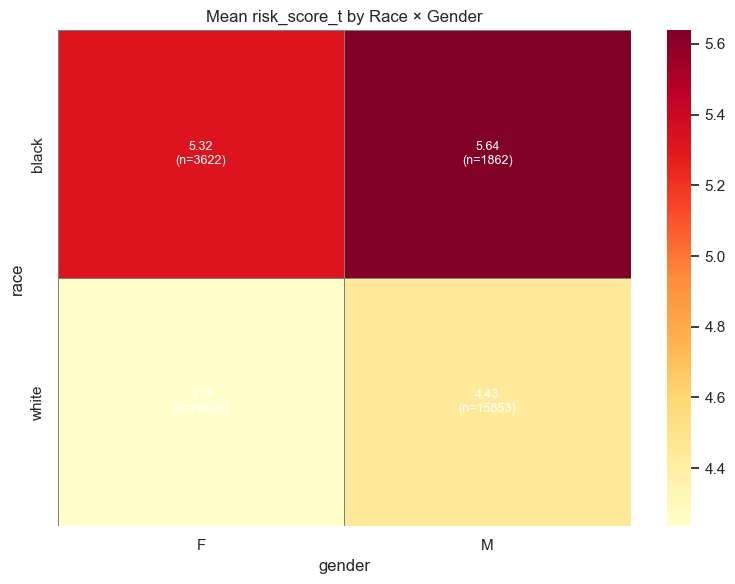

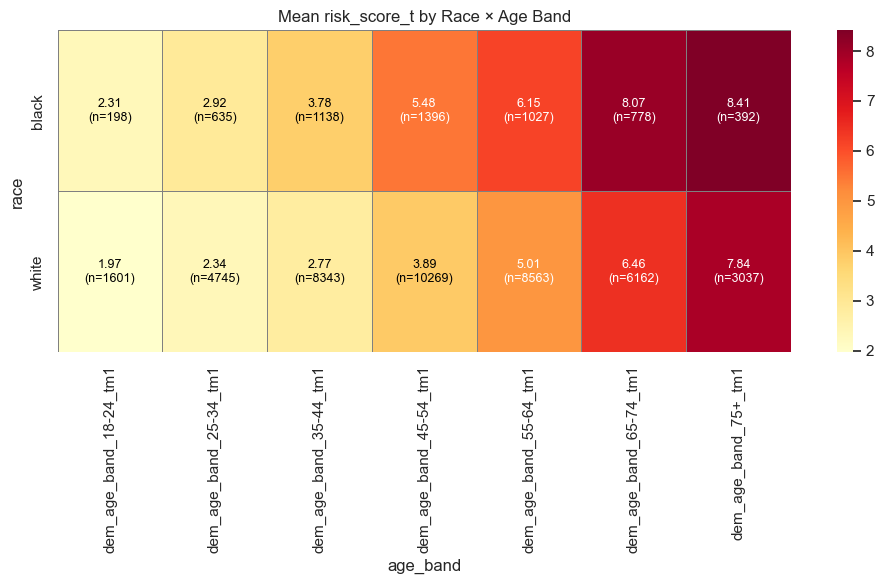

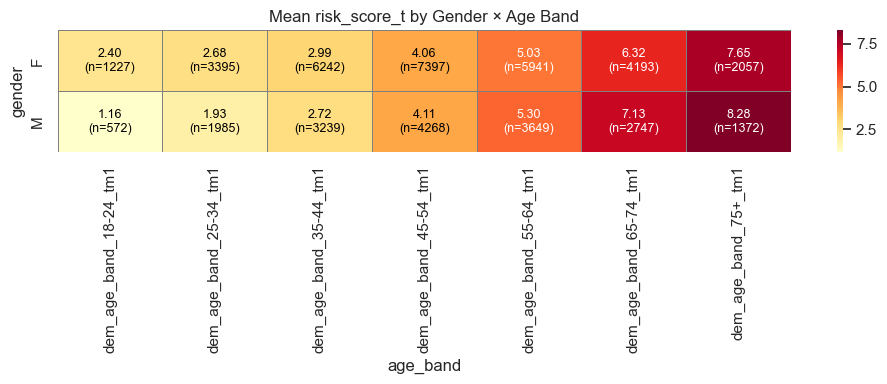

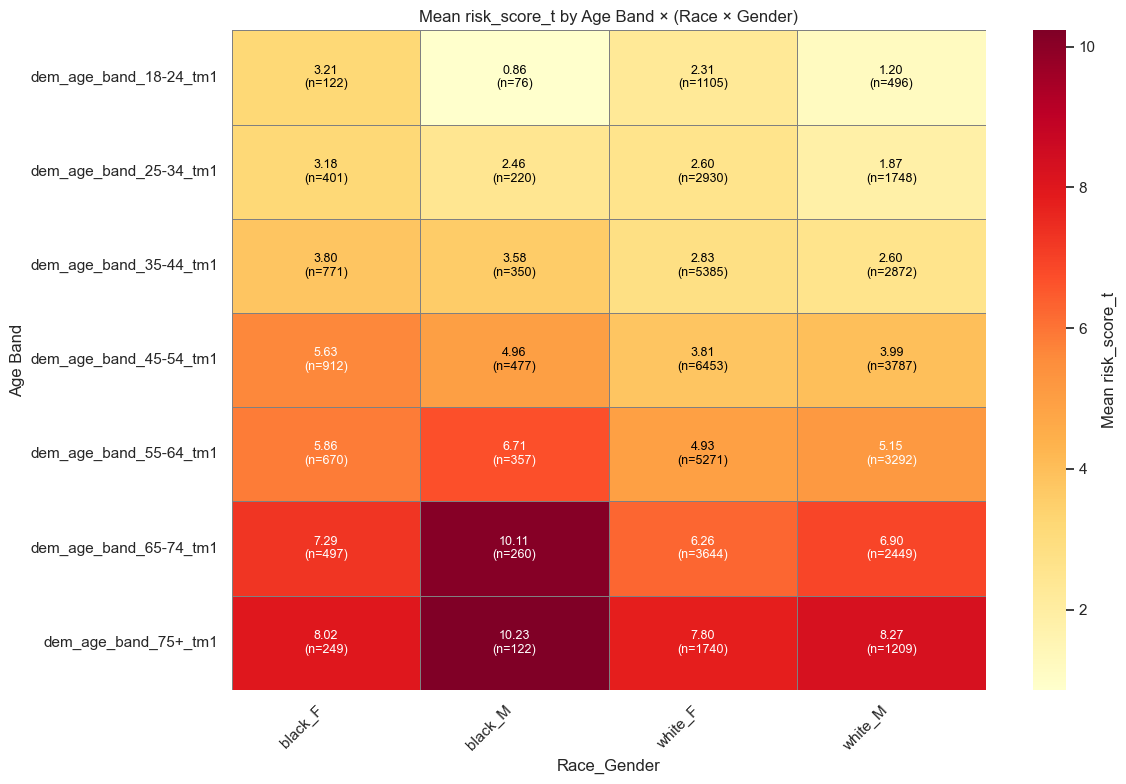

In [99]:
age_bands = [c for c in df.columns if c.startswith('dem_age_band')]
def extract_age_band(row):
    for band in age_bands:
        if row[band] == 1:
            return band
    return None

df['age_band'] = df.apply(extract_age_band, axis=1)
df = df[df['age_band'].notna()].copy()

# Define constants
outcome = 'risk_score_t'
min_n   = 30

# Build summary tables

# Race × Gender
rows_rg = []
for race in df['race'].astype(str).unique():
    for flag in [0, 1]:
        mask = (df['race']==race) & (df['dem_female']==flag)
        n = mask.sum()
        if n < min_n: continue
        rows_rg.append({
            'race': race,
            'gender': 'F' if flag else 'M',
            'n': n,
            f'mean_{outcome}': df.loc[mask, outcome].mean()
        })
df_rg = pd.DataFrame(rows_rg)

# Race × Age Band
rows_ra = []
for race in df['race'].astype(str).unique():
    for band in age_bands:
        mask = (df['race']==race) & (df[band]==1)
        n = mask.sum()
        if n < min_n: continue
        rows_ra.append({
            'race': race,
            'age_band': band,
            'n': n,
            f'mean_{outcome}': df.loc[mask, outcome].mean()
        })
df_ra = pd.DataFrame(rows_ra)

# Gender × Age Band
rows_ga = []
for flag in [0, 1]:
    for band in age_bands:
        mask = (df['dem_female']==flag) & (df[band]==1)
        n = mask.sum()
        if n < min_n: continue
        rows_ga.append({
            'gender': 'F' if flag else 'M',
            'age_band': band,
            'n': n,
            f'mean_{outcome}': df.loc[mask, outcome].mean()
        })
df_ga = pd.DataFrame(rows_ga)

# — 4) Plotting helper
def plot_heatmap_blocks(data, row, col, mean_col, count_col, title, figsize=(8,6)):
    mat = data.pivot(index=row, columns=col, values=mean_col)
    cnt = data.pivot(index=row, columns=col, values=count_col)
    mat = mat.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cnt = cnt.loc[mat.index, mat.columns]
    plt.figure(figsize=figsize)
    ax = sns.heatmap(mat, mask=mat.isna(), cmap='YlOrRd',
                     linewidths=0.5, linecolor='gray', cbar=True, annot=False)
    vmax = np.nanmax(mat.values)
    for y in range(mat.shape[0]):
        for x in range(mat.shape[1]):
            v = mat.iloc[y, x]
            if pd.notna(v):
                c = int(cnt.iloc[y, x])
                txt = f"{v:.2f}\n(n={c})"
                color = 'white' if v > 0.5*vmax else 'black'
                ax.text(x+0.5, y+0.5, txt, ha='center', va='center',
                        color=color, fontsize=9)
    ax.set_title(title)
    ax.set_ylabel(row)
    ax.set_xlabel(col)
    plt.tight_layout()
    plt.show()

# Draw the three simple heatmaps

plot_heatmap_blocks(
    df_rg, 'race', 'gender',
    mean_col=f'mean_{outcome}', count_col='n',
    title=f'Mean {outcome} by Race × Gender'
)

plot_heatmap_blocks(
    df_ra, 'race', 'age_band',
    mean_col=f'mean_{outcome}', count_col='n',
    title=f'Mean {outcome} by Race × Age Band',
    figsize=(10,6)
)

plot_heatmap_blocks(
    df_ga, 'gender', 'age_band',
    mean_col=f'mean_{outcome}', count_col='n',
    title=f'Mean {outcome} by Gender × Age Band',
    figsize=(10,4)
)

# One combined heatmap: Age Band × (Race × Gender)

df['race_gender'] = df['race'].astype(str) + '_' + df['dem_female'].map({0:'M',1:'F'})
summary = (
    df.groupby(['age_band','race_gender'])
      .agg(n=('risk_score_t','size'),
           rate=('risk_score_t','mean'))
      .reset_index()
)
mat_rate = summary.pivot(index='age_band', columns='race_gender', values='rate')
mat_n    = summary.pivot(index='age_band', columns='race_gender', values='n')

plt.figure(figsize=(12,8))
ax = sns.heatmap(
    mat_rate,
    mask=mat_rate.isna(),
    cmap='YlOrRd',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': f'Mean {outcome}'},
    annot=False
)
vmax = np.nanmax(mat_rate.values)
for y in range(mat_rate.shape[0]):
    for x in range(mat_rate.shape[1]):
        v = mat_rate.iloc[y,x]
        if pd.notna(v):
            c = int(mat_n.iloc[y,x])
            txt = f"{v:.2f}\n(n={c})"
            color = 'white' if v > 0.5*vmax else 'black'
            ax.text(x+0.5, y+0.5, txt, ha='center', va='center', color=color, fontsize=9)
ax.set_title(f'Mean {outcome} by Age Band × (Race × Gender)')
ax.set_ylabel('Age Band')
ax.set_xlabel('Race_Gender')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Diagnostic function that evaluates which rebalancing strategies might be needed for sensitive groups 

In [91]:
def recommend_rebalancing(df, sensitive_cols, target_col="target", min_group_prop=0.1, outcome_imbalance_thresh=0.1):
    """
    Evaluate dataset group balance and outcome disparities.
    Returns a dictionary with strategy recommendations per group.
    """
    from collections import defaultdict

    strategies = defaultdict(list)

    for col in sensitive_cols:
        group_props = df[col].value_counts(normalize=True)
        small_groups = group_props[group_props < min_group_prop].index.tolist()

        # Check group underrepresentation
        if small_groups:
            strategies[col].append(f"Oversample underrepresented groups: {small_groups}")

        # Target outcome imbalance
        target_rates = df.groupby(col)[target_col].mean()
        max_gap = target_rates.max() - target_rates.min()

        if max_gap > outcome_imbalance_thresh:
            strategies[col].append(f"Consider reweighting / fairness correction (target rate gap = {max_gap:.2f})")

        # Label imbalance (global)
        pos_rate = df[target_col].mean()
        if pos_rate < 0.3 or pos_rate > 0.7:
            strategies["general"].append("Detected class imbalance: consider SMOTE, undersampling, or reweighting")

    # Recommendation for stratified sampling
    # If multiple sensitive attributes, recommend stratification on their combination
    if len(sensitive_cols) > 1:
        strat_cols = " + ".join(sensitive_cols)
        strat_message = (
            f"For train-test split, use stratified sampling on the combination of [{strat_cols}] "
            "to ensure all subgroup combinations are represented proportionally."
        )
    else:
        strat_message = (
            f"For train-test split, use stratified sampling on [{sensitive_cols[0]}] "
            "to ensure subgroups are proportionally represented."
        )
    # Optionally, also suggest considering the target variable if relevant
    strat_message += " Optionally, also stratify on the target variable if label imbalance is present."

    strategies["general"].append(strat_message)

    return dict(strategies)


In [94]:
# Checks what fairness-related recommendations the recommend balancing function would make for the dataset using race and gender (dem_female) as sensitive features.
sensitive_features = ["race", "dem_female", "age_group"]
recommendations = recommend_rebalancing(df, sensitive_features)

for group, recs in recommendations.items():
    print(f"\n{group.upper()}")
    for r in recs:
        print("- " + r)



RACE
- Consider reweighting / fairness correction (target rate gap = 0.16)

AGE_GROUP
- Oversample underrepresented groups: ['75+', '18-24']
- Consider reweighting / fairness correction (target rate gap = 0.56)

GENERAL
- For train-test split, use stratified sampling on the combination of [race + dem_female + age_group] to ensure all subgroup combinations are represented proportionally. Optionally, also stratify on the target variable if label imbalance is present.


## 5.1 Output
The code suggests applying reweighting or fairness correction for both race and age group, due to substantial differences in target outcome rates (0.16 and 0.56, respectively). Additionally, the age groups 75+ and 18-24 are flagged as underrepresented and should be oversampled. Finally, it recommends using stratified sampling during train-test splitting across race, gender, and age group to maintain proportional subgroup representation and reduce bias during model evaluation.

# 6. Mutual Information (Discussion/Future work)
The code generates demographic, clinical, and cost-related features along with missing values. Missing values are then imputed using KNN imputation. It then visualizes distributions of race, gender, and age bands to inspect demographic balance. It calculates mutual information scores to identify which features are most predictive of key outcomes like program enrollment and risk score. Lastly, it checks how sensitive attributes (such as gender and age) correlate with outcomes and visualizes the top predictors using MI bar plots.

/Users/taramac-lean/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


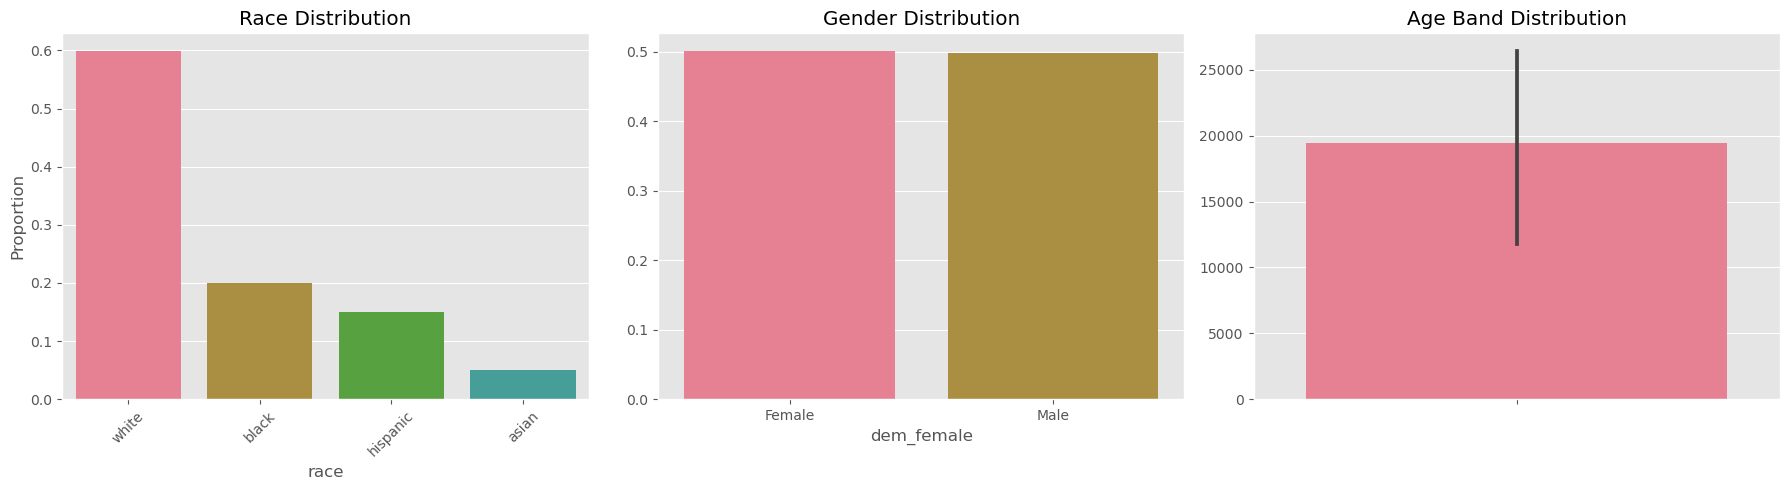


Top 10 features predicting program_enrolled_t:
dem_age_band_25-34_tm1     0.005462
dem_female                 0.004285
dem_age_band_55-64_tm1     0.004199
gagne_sum_tm1              0.003498
dem_age_band_65-74_tm1     0.003371
diabetes_elixhauser_tm1    0.003360
dem_age_band_35-44_tm1     0.002420
ghba1c_mean_tm1            0.001562
risk_score_t               0.001559
dem_age_band_75+_tm1       0.001421
dtype: float64

Top 10 features predicting risk_score_t:
dem_age_band_45-54_tm1         0.003907
race                           0.003187
hypertension_elixhauser_tm1    0.002870
cost_emergency_tm1             0.002617
program_enrolled_t             0.001559
ghba1c_mean_tm1                0.001451
diabetes_elixhauser_tm1        0.001072
cost_t                         0.000190
dem_age_band_75+_tm1           0.000096
dem_age_band_35-44_tm1         0.000083
dtype: float64

MI between sensitive attributes and program enrollment:
race: 0.0020
dem_female: 0.0051
dem_age_band_18-24_tm1: 0.0012


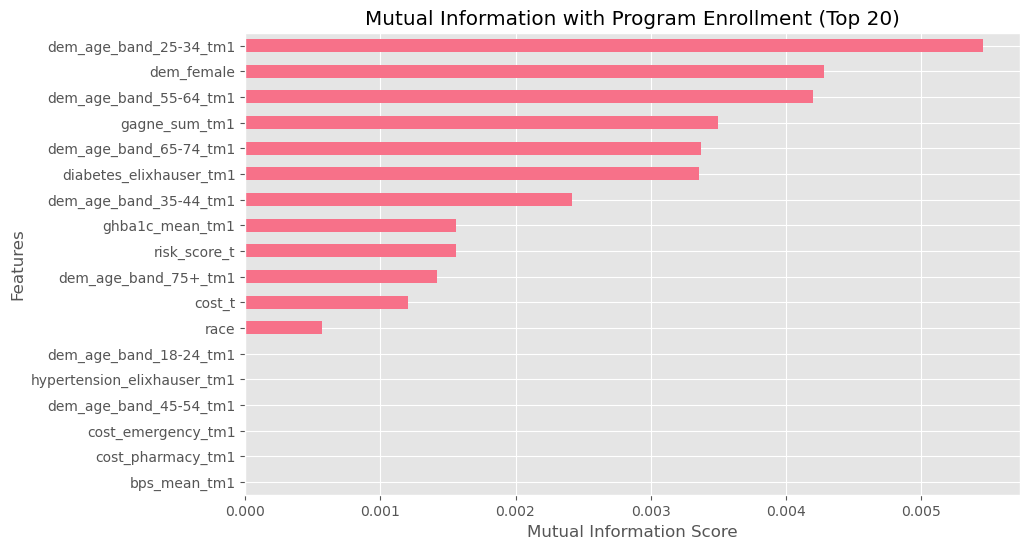

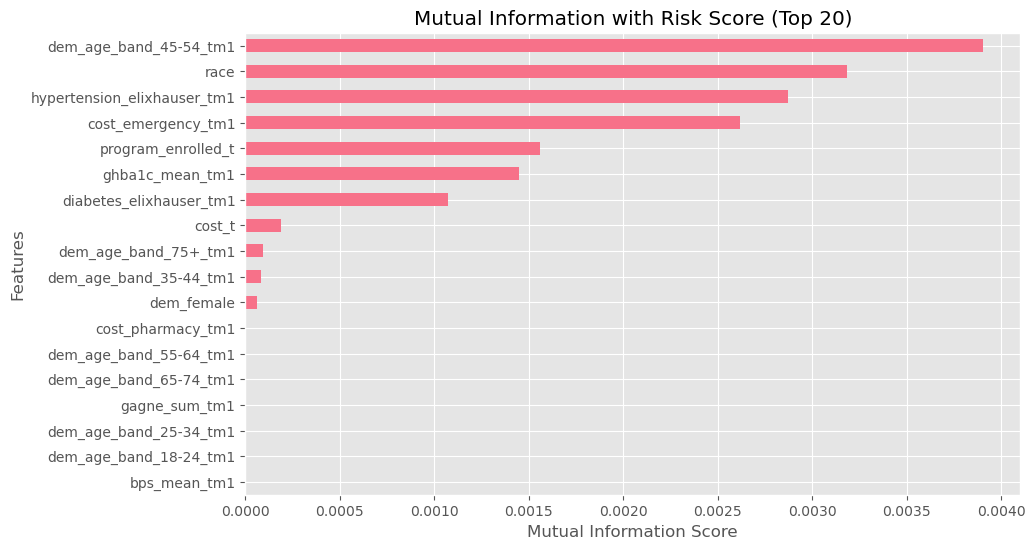

In [8]:
# Set style for visualizations
plt.style.use('ggplot')
sns.set_palette("husl")

# Data Preparation

num_rows = 48784
data = {
    # Demographic variables
    'race': np.random.choice(['white', 'black', 'hispanic', 'asian'], size=num_rows, p=[0.6, 0.2, 0.15, 0.05]),
    'dem_female': np.random.randint(0, 2, size=num_rows),
    'dem_age_band_18-24_tm1': (np.random.random(size=num_rows) > 0.9).astype(int),
    'dem_age_band_25-34_tm1': (np.random.random(size=num_rows) > 0.8).astype(int),
    'dem_age_band_35-44_tm1': (np.random.random(size=num_rows) > 0.7).astype(int),
    'dem_age_band_45-54_tm1': (np.random.random(size=num_rows) > 0.6).astype(int),
    'dem_age_band_55-64_tm1': (np.random.random(size=num_rows) > 0.5).astype(int),
    'dem_age_band_65-74_tm1': (np.random.random(size=num_rows) > 0.4).astype(int),
    'dem_age_band_75+_tm1': (np.random.random(size=num_rows) > 0.3).astype(int),
    
    # Target variables (time t)
    'risk_score_t': np.random.gamma(2, 0.5, size=num_rows),
    'program_enrolled_t': np.random.randint(0, 2, size=num_rows),
    'cost_t': np.random.lognormal(5, 1, size=num_rows),
    
    # Some comorbidity variables (time t-1)
    'gagne_sum_tm1': np.random.poisson(2, size=num_rows),
    'hypertension_elixhauser_tm1': (np.random.random(size=num_rows) > 0.7).astype(int),
    'diabetes_elixhauser_tm1': (np.random.random(size=num_rows) > 0.8).astype(int),
    
    # Some cost variables (time t-1)
    'cost_emergency_tm1': np.random.lognormal(3, 1, size=num_rows),
    'cost_pharmacy_tm1': np.random.lognormal(4, 1, size=num_rows),
    
    # Some biomarker variables (time t-1)
    'ghba1c_mean_tm1': np.random.normal(5.5, 1, size=num_rows),
    'bps_mean_tm1': np.random.normal(120, 15, size=num_rows)
}

# Create DataFrame first
df = pd.DataFrame(data)

# Add some missing values (10% missing in some columns) 
cols_with_missing = ['ghba1c_mean_tm1', 'bps_mean_tm1', 'cost_emergency_tm1']
for col in cols_with_missing:
    df[col] = df[col].where(np.random.random(size=num_rows) > 0.1, other=np.nan)

# Step 2: Handle Missing Values

def handle_missing_values(df, strategy='knn'):
    """Handle missing values based on selected strategy"""
    df_clean = df.copy()
    
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=np.number).columns
    categorical_cols = df.select_dtypes(exclude=np.number).columns
    
    # For categorical columns -> treat NaN as a separate category
    for col in categorical_cols:
        if df[col].isna().any():
            df_clean[col] = df[col].fillna('MISSING')
    
    # For numeric columns -> imputation
    if strategy == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    elif strategy == 'knn':
        imputer = KNNImputer(n_neighbors=5)
    else:
        raise ValueError("Invalid imputation strategy")
    
    df_clean[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    return df_clean

df_clean = handle_missing_values(df, strategy='knn')

# Demographic Visualization

def plot_demographic_distributions(df):
    """Visualize distributions of key demographic variables"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Race distribution
    race_counts = df['race'].value_counts(normalize=True)
    sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[0])
    axes[0].set_title('Race Distribution')
    axes[0].set_ylabel('Proportion')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Gender distribution
    gender_map = {0: 'Male', 1: 'Female'}
    gender_counts = df['dem_female'].map(gender_map).value_counts(normalize=True)
    sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[1])
    axes[1].set_title('Gender Distribution')
    
    # Age distribution
    age_bands = [col for col in df.columns if 'dem_age_band' in col]
    age_counts = df[age_bands].sum().sort_index()
    age_labels = [col.split('_')[-1].replace('tm1', '') for col in age_counts.index]
    sns.barplot(x=age_labels, y=age_counts.values, ax=axes[2])
    axes[2].set_title('Age Band Distribution')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_demographic_distributions(df)

# Mutual Information Analysis

def calculate_mutual_information(df, target_col, problem_type='classification'):
    """
    Calculate mutual information between features and target variable.
    
    Parameters:
    - df: DataFrame containing features and target
    - target_col: Name of the target column
    - problem_type: 'classification' or 'regression'
    
    Returns:
    - Series with MI scores indexed by feature names
    """
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Encode categorical variables
    categorical_cols = X.select_dtypes(exclude=np.number).columns
    for col in categorical_cols:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    
    # Calculate mutual information
    if problem_type == 'classification':
        mi_scores = mutual_info_classif(X, y, discrete_features='auto')
    else:
        mi_scores = mutual_info_regression(X, y)
    
    mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    return mi_series

# MI for program enrollment (classification)
target = 'program_enrolled_t'
mi_program = calculate_mutual_information(df_clean, target, 'classification')
print(f"\nTop 10 features predicting {target}:")
print(mi_program.head(10))

# MI for risk score (regression)
target = 'risk_score_t'
mi_risk = calculate_mutual_information(df_clean, target, 'regression')
print(f"\nTop 10 features predicting {target}:")
print(mi_risk.head(10))

# Check if sensitive attributes predict outcomes
print("\nMI between sensitive attributes and program enrollment:")
sensitive_attrs = ['race', 'dem_female'] + [col for col in df.columns if 'dem_age_band' in col]
for attr in sensitive_attrs:
    mi = calculate_mutual_information(df_clean[[attr, 'program_enrolled_t']], 'program_enrolled_t', 'classification')
    print(f"{attr}: {mi.iloc[0]:.4f}")

# Visualization of MI Results

def plot_mi_scores(mi_scores, title):
    """Plot mutual information scores"""
    plt.figure(figsize=(10, 6))
    mi_scores.sort_values().tail(20).plot.barh()  # Show top 20 features
    plt.title(title)
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.show()

# Plot MI for program enrollment
plot_mi_scores(mi_program, 'Mutual Information with Program Enrollment (Top 20)')

# Plot MI for risk score
plot_mi_scores(mi_risk, 'Mutual Information with Risk Score (Top 20)')

## 6.1 Output Mutual Information
Regarding mutual information with program enrollment, the 25-34 age band is the strongest predictor of enrollment, followed by the female gender and older age bands. gagne_sum_t (total number of active chronic illnesses) and diabetes history also carry noteworthy information. Meaning that patients with more comorbidities or with a history of diabetes tend to have a different enrollment probability than patients without. The future risk score tends to carry some information about enrollment.

For predicting the risk score, middle-aged patients are the most "risky"; the 45-54 band is the top predictor of the risk_score. Race, as a single categorical encoding, and prior hypertension history both inform the risk model. Being enrolled in the program itself is modestly predictive of the risk score. 

Observing the sensitive attribute (race/gender/age) MI with enrollment and examining how much sensitive attributes alone predict enrollment, it indicates that all sensitive attributes are nonzero, and therefore it specifies that they carry information about who gets enrolled. The largest sensitive MI (which was the age group 75+) suggests underlying selection biases vary sharply by age. 

In conclusion, although the MI values are low, the rank ordering reliably indicates which features most reduce uncertainty about each target. Both enrollment and risk models rely heavily on age and gender. 